# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `FirstnameLastname.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it by adding the source of the code as a comment in the first line of the code cell.
- In real life clients can give unclear goals or requirements. So, if the instructions seem vague, use common sense to make reasonable assumptions.

# Task 1: [Where's Waldo?](https://www.wikihow.com/Find-Waldo) (35 points)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  What you need to do
For this task, you are required to build a fully connect feed-forward ANN model
for a classification problem.

For the given data, you need do proper data preprocessing, data analysis,
design the ANN model, then fine-tune your model architecture.

For evaluating your model, do $ 80/20 $ train test split.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Identify the appropriate classification approach for a given problem. 20%
- Apply ANNs to solve a classification problem (basic training, validation, testing -- without fine tuning). 50%
- Fine-tune to determine the optimal model architecture. 20%


### Data
You will be working with the data in `Task_1.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - location
 - sites
 - time
 - date

After training, evaluate you model by print [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
on your test set. 

Then predicting each user in `task_1_verify.csv` whether it's Waldo or not. Your output should look like the following:

`row_idx: is_waldo`, notice if the user is waldo your output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



In [162]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

df = pd.read_csv('task 1.csv')
df.head()

index            browser          os locale  user_id          location   
0   8909            Firefox  Windows 10  zh-CN       46    China/Shanghai  \
1  17679  Internet Explorer   Windows 8  ro-RO       21    Germany/Berlin   
2  11803  Internet Explorer       MacOS  ur-PK       98  Australia/Sydney   
3    356  Internet Explorer      Ubuntu  pl-PL       44       Japan/Tokyo   
4  10948  Internet Explorer   Windows 8  bg-BG       59       Japan/Tokyo   

                                               sites      time        date  
0  [{'site': '1.static.dpreview.com', 'length': 1...  14:14:00  2016-01-28  
1  [{'site': 'safebrowsing-cache.google.com', 'le...  05:23:00  2016-08-26  
2  [{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...  12:03:00  2016-03-13  
3  [{'site': 'fr.hdscreen.me', 'length': 16}, {'s...  06:08:00  2017-01-19  
4  [{'site': '193.164.196.50', 'length': 10}, {'s...  03:59:00  2017-05-13

Inspect for any missing values.

In [163]:

df.isnull().sum()

index       0
browser     0
os          0
locale      0
user_id     0
location    0
sites       0
time        0
date        0
dtype: int64

Examine the count of distinct values in every column.

In [164]:
df.nunique()

index       20401
browser         4
os              6
locale         25
user_id       200
location       21
sites       20388
time         1440
date          621
dtype: int64

### sites
Excluding the "sites" column from the analysis because it requires parsing, and including it will generate a significant number of features. And as we will see later, this will not affect the result in any way.
### location
location splitted to country and city
### time
Time converted to seconds
### date
Date separated to day, month and year
### user_id
user_id = 1 if it's waldo and user_id = 0 otherwise


In [165]:

def preprocess(df):
    df.drop('sites', axis=1, inplace=True)
    if 'index' in df.columns:
        df.drop('index', axis=1, inplace=True)
    #split location into contry and city
    df['city'] = df['location'].apply(lambda x: x.split('/')[1])
    df['country'] = df['location'].apply(lambda x: x.split('/')[0])
    df.drop('location', axis=1, inplace=True)
    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].apply(lambda x: 1 if x == 0 else 0)
    #split date into year, month, day
    df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
    df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
    df['day'] = df['date'].apply(lambda x: int(x.split('-')[2]))
    df.drop('date', axis=1, inplace=True)
    df['sec'] = df['time'].apply(lambda x: list(map(int, x.split(':')))[0]*3600 + list(map(int, x.split(':')))[1]*60 + list(map(int, x.split(':')))[2])
    df.drop('time', axis=1, inplace=True)
preprocess(df)
df.head()

browser          os locale  user_id      city    country  year   
0            Firefox  Windows 10  zh-CN        0  Shanghai      China  2016  \
1  Internet Explorer   Windows 8  ro-RO        0    Berlin    Germany  2016   
2  Internet Explorer       MacOS  ur-PK        0    Sydney  Australia  2016   
3  Internet Explorer      Ubuntu  pl-PL        0     Tokyo      Japan  2017   
4  Internet Explorer   Windows 8  bg-BG        0     Tokyo      Japan  2017   

   month  day    sec  
0      1   28  51240  
1      8   26  19380  
2      3   13  43380  
3      1   19  22080  
4      5   13  14340

In [166]:
categorical = ['browser', 'os', 'locale', 'city', 'country']
numerical = ['year', 'month', 'day', 'sec']

Dataset is imbalanced

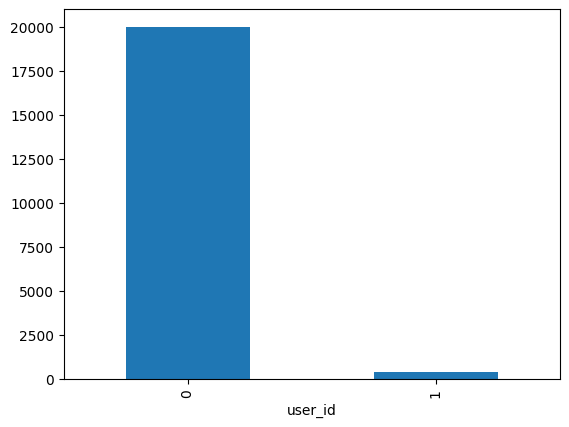

In [167]:
df['user_id'].value_counts().plot(kind='bar')
plt.show()

In [168]:
from sklearn.model_selection import train_test_split
X = df.drop('user_id', axis=1)
y = df['user_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## X_train
We can observe that Waldo is characterized by:
- browser: Firefox or Chrome
- os: Windows 10 or Ubuntu
- locale: ru_RU
- city: Toronto, Chicago or Paris
- country: Canada, USA, France


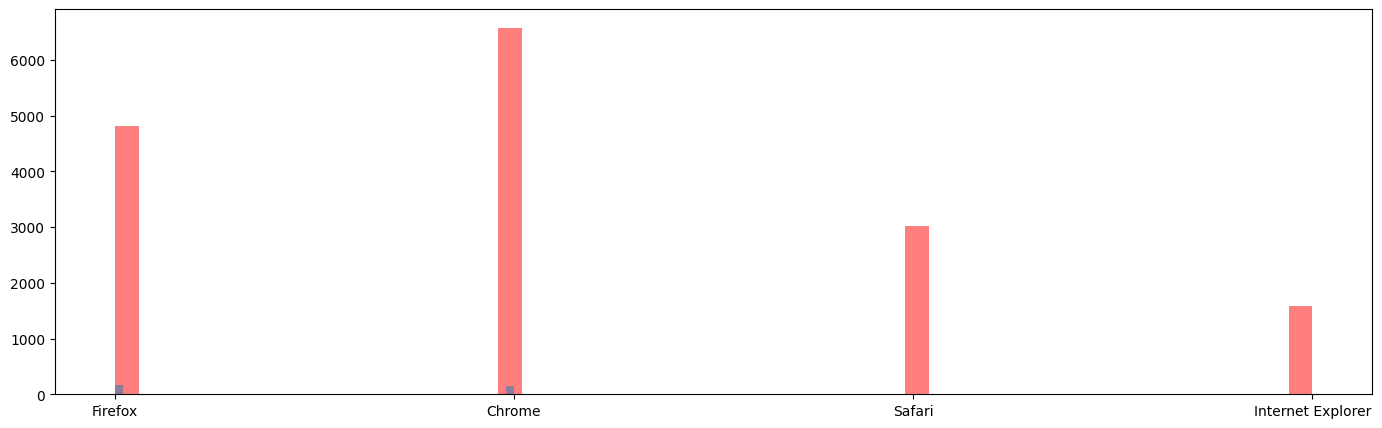

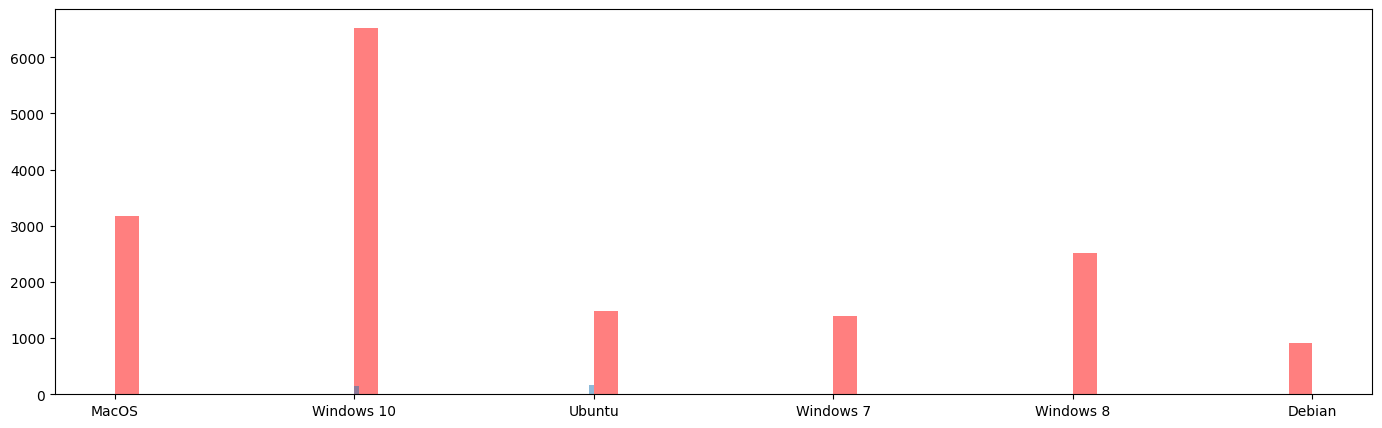

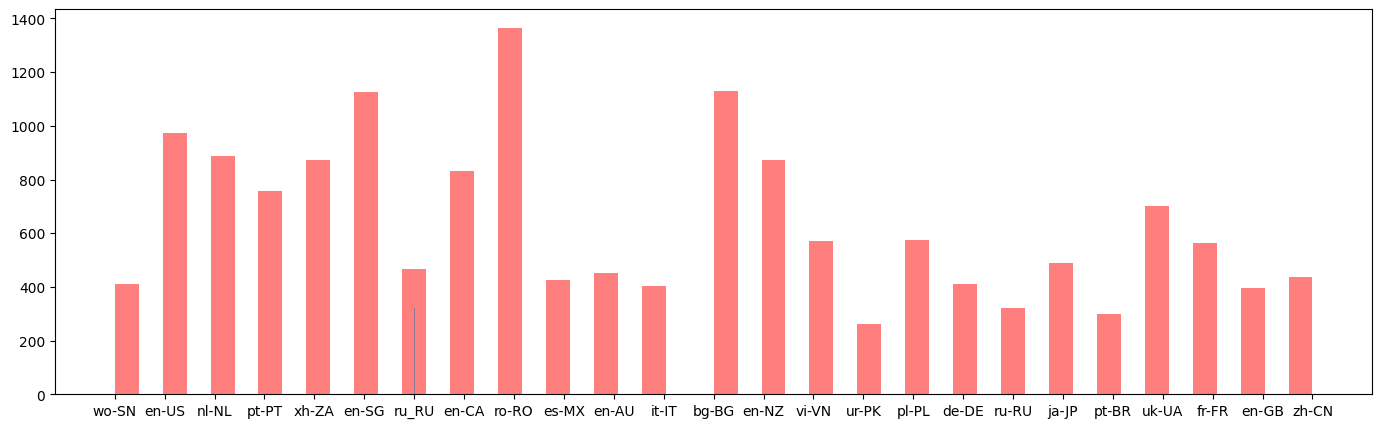

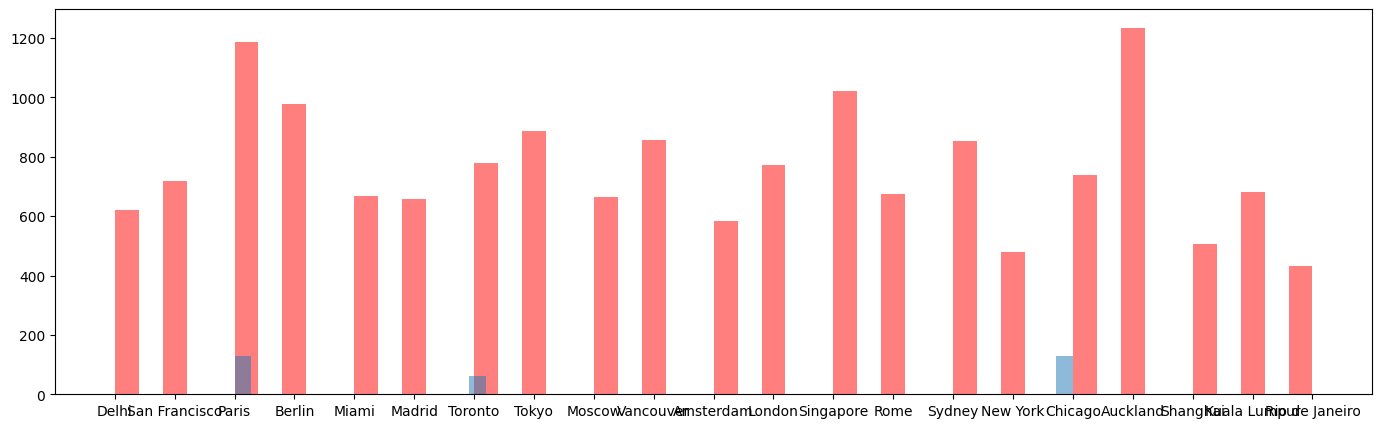

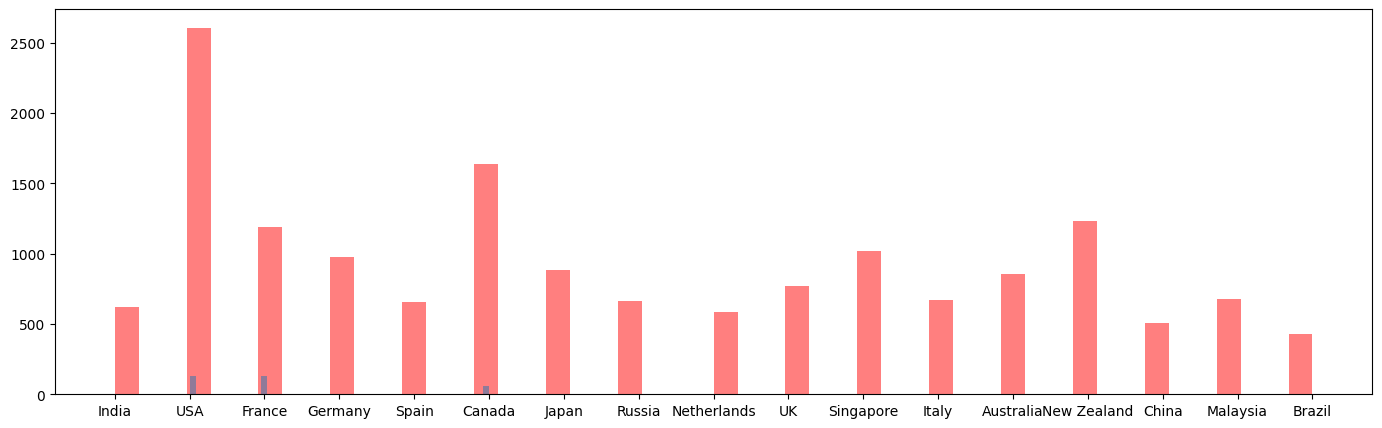

In [169]:
for col in categorical:
    plt.figure(figsize=(17, 5))
    plt.hist(X_train[y_train == 0][col], bins=50, alpha=0.5, label='user_id = 0', color='red')
    plt.hist(X_train[y_train == 1][col], bins=50, alpha=0.5, label='user_id = 1')

    plt.show()

No outliers in train dataset

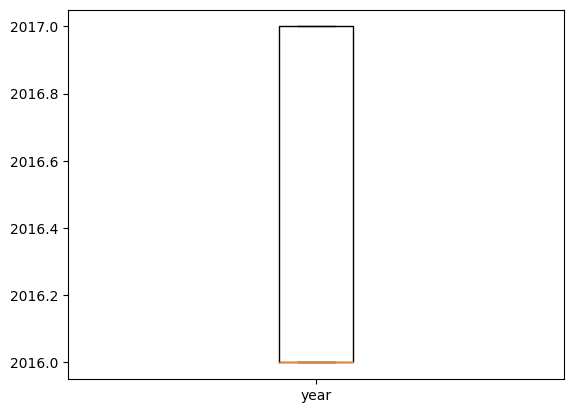

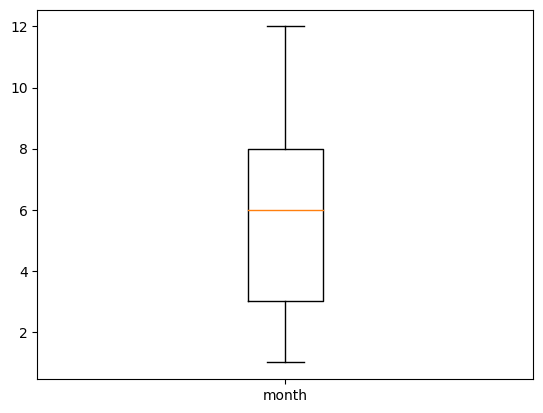

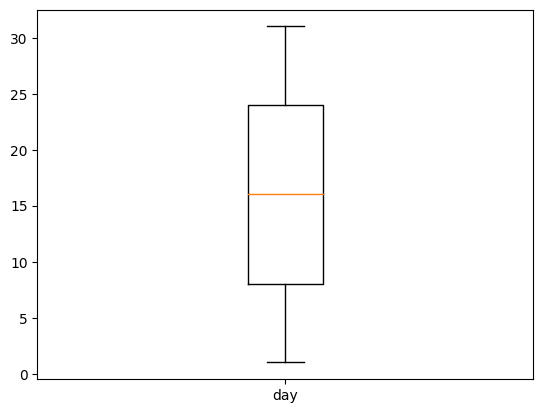

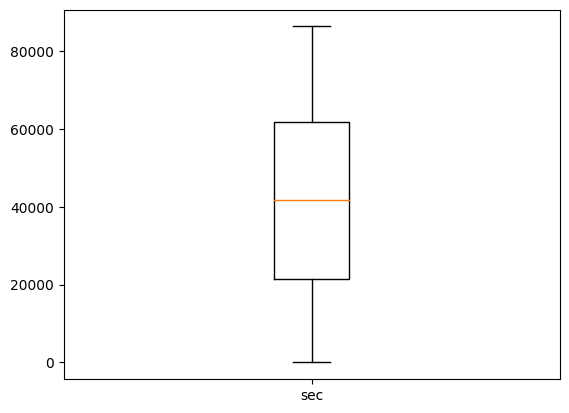

In [170]:
for i, col in enumerate(numerical):
    plt.boxplot(x = X_train[col], labels = [col])
    plt.show()

No duplicate rows in train dataset

In [171]:
#show duplicated rows
X_train[X_train.duplicated()]


Empty DataFrame
Columns: [browser, os, locale, city, country, year, month, day, sec]
Index: []

No missing values in train dataset

In [172]:
X_train.isnull().sum()

browser    0
os         0
locale     0
city       0
country    0
year       0
month      0
day        0
sec        0
dtype: int64

One hot encoding for categorical features

In [50]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train[categorical]), columns=ohe.get_feature_names_out(categorical))
X_train = X_train.drop(categorical, axis=1)

X_train_cat_ohe.index = X_train.index

X_train[ohe.get_feature_names_out(categorical)] = X_train_cat_ohe
X_train

year  month  day    sec  browser_Chrome  browser_Firefox   
9466   2016      8    6  51240             0.0              1.0  \
7117   2016      4   20  78780             1.0              0.0   
245    2016      5   23  18900             0.0              0.0   
15595  2016      9    2  49380             0.0              0.0   
13673  2016      4   25  84060             0.0              1.0   
...     ...    ...  ...    ...             ...              ...   
4769   2017      8    3  32880             0.0              1.0   
16200  2017      7    6  77940             1.0              0.0   
17531  2016      5   25  35520             0.0              0.0   
15577  2017      8   15  46980             1.0              0.0   
16461  2016      8    5  73380             0.0              0.0   

       browser_Internet Explorer  browser_Safari  os_Debian  os_MacOS  ...   
9466                         0.0             0.0        0.0       0.0  ...  \
7117                         0.0             0.0        0.0       0.0  ...   
245                          1.0             0.0        0.0       0.0  ...   
15595                        1.0             0.0        0.0       0.0  ...   
13673                        0.0             0.0        0.0       0.0  ...   
...                          ...             ...        ...       ...  ...   
4769                         0.0             0.0        1.0       0.0  ...   
16200                        0.0             0.0        1.0       0.0  ...   
17531                        1.0             0.0        0.0       0.0  ...   
15577                        0.0             0.0        0.0       1.0  ...   
16461                        0.0             1.0        0.0       0.0  ...   

       country_Italy  country_Japan  country_Malaysia  country_Netherlands   
9466             0.0            0.0               1.0                  0.0  \
7117             0.0            0.0               0.0                  0.0   
245              0.0            0.0               0.0                  0.0   
15595            0.0            0.0               0.0                  0.0   
13673            0.0            0.0               0.0                  0.0   
...              ...            ...               ...                  ...   
4769             0.0            0.0               0.0                  0.0   
16200            0.0            0.0               0.0                  0.0   
17531            0.0            0.0               0.0                  0.0   
15577            0.0            0.0               0.0                  0.0   
16461            0.0            0.0               0.0                  0.0   

       country_New Zealand  country_Russia  country_Singapore  country_Spain   
9466                   0.0             0.0                0.0            0.0  \
7117                   0.0             0.0                0.0            0.0   
245                    0.0             0.0                0.0            0.0   
15595                  0.0             0.0                0.0            0.0   
13673                  0.0             0.0                0.0            1.0   
...                    ...             ...                ...            ...   
4769                   0.0             0.0                0.0            0.0   
16200                  0.0             0.0                0.0            0.0   
17531                  1.0             0.0                0.0            0.0   
15577                  0.0             0.0                0.0            0.0   
16461                  0.0             0.0                0.0            0.0   

       country_UK  country_USA  
9466          0.0          0.0  
7117          0.0          0.0  
245           1.0          0.0  
15595         0.0          0.0  
13673         0.0          0.0  
...           ...          ...  
4769          0.0          0.0  
16200         0.0          0.0  
17531         0.0          0.0  
15577         0.0          0.0  
1646

The Cyclical Transform is applied to data with cyclical patterns, such as months, days, or time in seconds, because it maps these features onto a circle, preserving their cyclic nature and enabling algorithms to better capture their patterns.

Standard Scaling is used for the year feature because it rescales the data to have a mean of zero and a standard deviation of one, which can help to normalize the data.

In [51]:
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import StandardScaler

cyclical = CyclicalFeatures(variables=['day', 'month', 'sec'], drop_original=True)
X_train = cyclical.fit_transform(X_train)


scaler = StandardScaler()
X_train['year'] = scaler.fit_transform(X_train[['year']])

X_train


year  browser_Chrome  browser_Firefox  browser_Internet Explorer   
9466  -0.840900             0.0              1.0                        0.0  \
7117  -0.840900             1.0              0.0                        0.0   
245   -0.840900             0.0              0.0                        1.0   
15595 -0.840900             0.0              0.0                        1.0   
13673 -0.840900             0.0              1.0                        0.0   
...         ...             ...              ...                        ...   
4769   1.189202             0.0              1.0                        0.0   
16200  1.189202             1.0              0.0                        0.0   
17531 -0.840900             0.0              0.0                        1.0   
15577  1.189202             1.0              0.0                        0.0   
16461 -0.840900             0.0              0.0                        0.0   

       browser_Safari  os_Debian  os_MacOS  os_Ubuntu  os_Windows 10   
9466              0.0        0.0       0.0        0.0            1.0  \
7117              0.0        0.0       0.0        0.0            0.0   
245               0.0        0.0       0.0        0.0            0.0   
15595             0.0        0.0       0.0        0.0            0.0   
13673             0.0        0.0       0.0        0.0            1.0   
...               ...        ...       ...        ...            ...   
4769              0.0        1.0       0.0        0.0            0.0   
16200             0.0        1.0       0.0        0.0            0.0   
17531             0.0        0.0       0.0        0.0            1.0   
15577             0.0        0.0       1.0        0.0            0.0   
16461             1.0        0.0       0.0        0.0            0.0   

       os_Windows 7  ...  country_Singapore  country_Spain  country_UK   
9466            0.0  ...                0.0            0.0         0.0  \
7117            0.0  ...                0.0            0.0         0.0   
245             1.0  ...                0.0            0.0         1.0   
15595           1.0  ...                0.0            0.0         0.0   
13673           0.0  ...                0.0            1.0         0.0   
...             ...  ...                ...            ...         ...   
4769            0.0  ...                0.0            0.0         0.0   
16200           0.0  ...                0.0            0.0         0.0   
17531           0.0  ...                0.0            0.0         0.0   
15577           0.0  ...                0.0            0.0         0.0   
16461           0.0  ...                0.0            0.0         0.0   

       country_USA   day_sin   day_cos  month_sin     month_cos   sec_sin   
9466           0.0  0.937752  0.347305  -0.866025 -5.000000e-01 -0.554094  \
7117           0.0 -0.790776 -0.612106   0.866025 -5.000000e-01 -0.522824   
245            0.0 -0.998717 -0.050649   0.500000 -8.660254e-01  0.980971   
15595          0.0  0.394356  0.918958  -1.000000 -1.836970e-16 -0.436692   
13673          0.0 -0.937752  0.347305   0.866025 -5.000000e-01 -0.165161   
...            ...       ...       ...        ...           ...       ...   
4769           0.0  0.571268  0.820763  -0.866025 -5.000000e-01  0.680782   
16200          0.0  0.937752  0.347305  -0.500000 -8.660254e-01 -0.573924   
17531          0.0 -0.937752  0.347305   0.500000 -8.660254e-01  0.528396   
15577          0.0  0.101168 -0.994869  -0.866025 -5.000000e-01 -0.273725   
16461          0.0  0.848644  0.528964  -0.866025 -5.000000e-01 -0.809402   

        sec_cos  
9466  -0.832454  
7117   0.852440  
245    0.194153  
15595 -0.899611  
13673  0.986267  
...         ...  
4769  -0.732486  
16200  0.818908  
17531 -0.848998  
15577 -0.961808  
16461  0.587255  

[16320 rows x 80 columns]

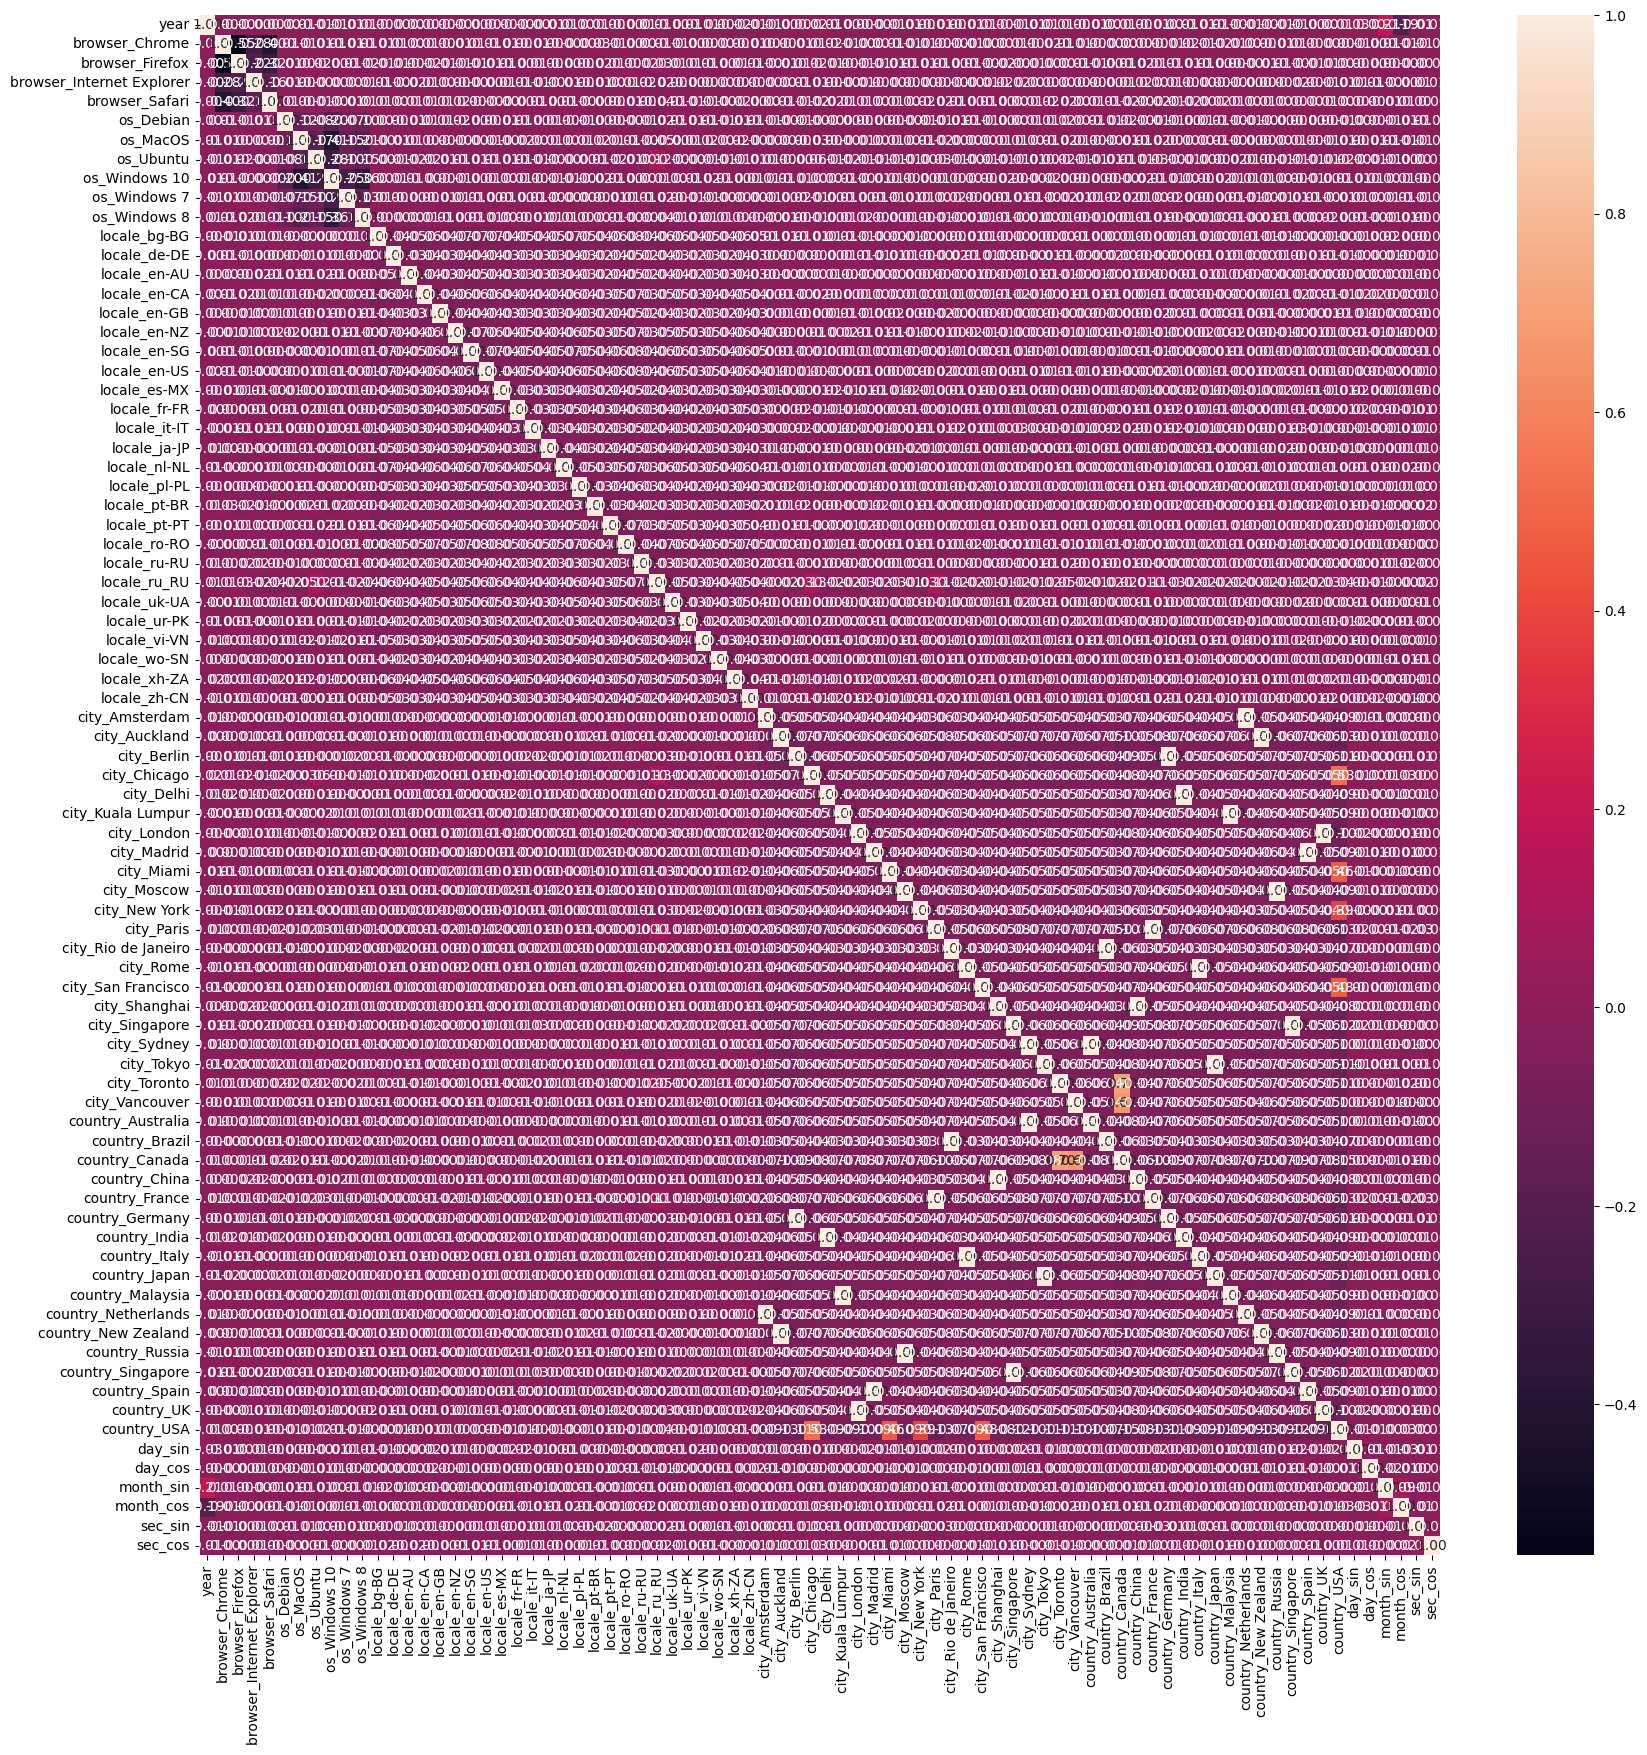

In [52]:
import seaborn as sns
corr = X_train.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()


## X_test
Same transformations with test data

In [54]:
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test[categorical]), columns=ohe.get_feature_names_out(categorical))
X_test = X_test.drop(categorical, axis=1)

X_test_cat_ohe.index = X_test.index

X_test[ohe.get_feature_names_out(categorical)] = X_test_cat_ohe
X_test

year  month  day    sec  browser_Chrome  browser_Firefox   
12711  2017      9    1  62100             0.0              1.0  \
10748  2016      2    2  47340             1.0              0.0   
6392   2016      9   16   7200             0.0              1.0   
4136   2016      5   12  73080             0.0              1.0   
4396   2016      3   28  40500             0.0              1.0   
...     ...    ...  ...    ...             ...              ...   
4593   2016      9    1  10620             0.0              0.0   
16712  2017      6   24  52020             0.0              0.0   
796    2017      5    3   6780             0.0              0.0   
7253   2016      5   25  51240             0.0              0.0   
11539  2017      4    9  57000             0.0              0.0   

       browser_Internet Explorer  browser_Safari  os_Debian  os_MacOS  ...   
12711                        0.0             0.0        0.0       0.0  ...  \
10748                        0.0             0.0        0.0       0.0  ...   
6392                         0.0             0.0        0.0       0.0  ...   
4136                         0.0             0.0        0.0       0.0  ...   
4396                         0.0             0.0        0.0       0.0  ...   
...                          ...             ...        ...       ...  ...   
4593                         1.0             0.0        0.0       1.0  ...   
16712                        1.0             0.0        0.0       0.0  ...   
796                          1.0             0.0        0.0       0.0  ...   
7253                         1.0             0.0        0.0       0.0  ...   
11539                        0.0             1.0        0.0       1.0  ...   

       country_Italy  country_Japan  country_Malaysia  country_Netherlands   
12711            0.0            0.0               0.0                  0.0  \
10748            0.0            0.0               0.0                  0.0   
6392             0.0            0.0               1.0                  0.0   
4136             0.0            0.0               0.0                  0.0   
4396             0.0            0.0               0.0                  0.0   
...              ...            ...               ...                  ...   
4593             0.0            0.0               1.0                  0.0   
16712            0.0            0.0               0.0                  0.0   
796              0.0            0.0               0.0                  0.0   
7253             0.0            0.0               0.0                  0.0   
11539            0.0            0.0               0.0                  0.0   

       country_New Zealand  country_Russia  country_Singapore  country_Spain   
12711                  0.0             0.0                0.0            0.0  \
10748                  0.0             0.0                0.0            0.0   
6392                   0.0             0.0                0.0            0.0   
4136                   0.0             0.0                0.0            0.0   
4396                   0.0             0.0                0.0            0.0   
...                    ...             ...                ...            ...   
4593                   0.0             0.0                0.0            0.0   
16712                  0.0             0.0                0.0            0.0   
796                    0.0             0.0                1.0            0.0   
7253                   0.0             0.0                0.0            0.0   
11539                  0.0             0.0                0.0            0.0   

       country_UK  country_USA  
12711         0.0          0.0  
10748         0.0          0.0  
6392          0.0          0.0  
4136          0.0          1.0  
4396          0.0          0.0  
...           ...          ...  
4593          0.0          0.0  
16712         0.0          1.0  
796           0.0          0.0  
7253          0.0          1.0  
1153

In [55]:
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import StandardScaler


X_test = cyclical.transform(X_test)

X_test['year'] = scaler.transform(X_test[['year']])
X_test

year  browser_Chrome  browser_Firefox  browser_Internet Explorer   
12711  1.189202             0.0              1.0                        0.0  \
10748 -0.840900             1.0              0.0                        0.0   
6392  -0.840900             0.0              1.0                        0.0   
4136  -0.840900             0.0              1.0                        0.0   
4396  -0.840900             0.0              1.0                        0.0   
...         ...             ...              ...                        ...   
4593  -0.840900             0.0              0.0                        1.0   
16712  1.189202             0.0              0.0                        1.0   
796    1.189202             0.0              0.0                        1.0   
7253  -0.840900             0.0              0.0                        1.0   
11539  1.189202             0.0              0.0                        0.0   

       browser_Safari  os_Debian  os_MacOS  os_Ubuntu  os_Windows 10   
12711             0.0        0.0       0.0        0.0            1.0  \
10748             0.0        0.0       0.0        0.0            0.0   
6392              0.0        0.0       0.0        0.0            1.0   
4136              0.0        0.0       0.0        0.0            0.0   
4396              0.0        0.0       0.0        0.0            1.0   
...               ...        ...       ...        ...            ...   
4593              0.0        0.0       1.0        0.0            0.0   
16712             0.0        0.0       0.0        1.0            0.0   
796               0.0        0.0       0.0        0.0            1.0   
7253              0.0        0.0       0.0        0.0            1.0   
11539             1.0        0.0       1.0        0.0            0.0   

       os_Windows 7  ...  country_Singapore  country_Spain  country_UK   
12711           0.0  ...                0.0            0.0         0.0  \
10748           0.0  ...                0.0            0.0         0.0   
6392            0.0  ...                0.0            0.0         0.0   
4136            0.0  ...                0.0            0.0         0.0   
4396            0.0  ...                0.0            0.0         0.0   
...             ...  ...                ...            ...         ...   
4593            0.0  ...                0.0            0.0         0.0   
16712           0.0  ...                0.0            0.0         0.0   
796             0.0  ...                1.0            0.0         0.0   
7253            0.0  ...                0.0            0.0         0.0   
11539           0.0  ...                0.0            0.0         0.0   

       country_USA   day_sin   day_cos     month_sin     month_cos   sec_sin   
12711          0.0  0.201299  0.979530 -1.000000e+00 -1.836970e-16 -0.981393  \
10748          0.0  0.394356  0.918958  8.660254e-01  5.000000e-01 -0.298826   
6392           0.0 -0.101168 -0.994869 -1.000000e+00 -1.836970e-16  0.500315   
4136           1.0  0.651372 -0.758758  5.000000e-01 -8.660254e-01 -0.822029   
4396           0.0 -0.571268  0.820763  1.000000e+00  6.123234e-17  0.193083   
...            ...       ...       ...           ...           ...       ...   
4593           0.0  0.201299  0.979530 -1.000000e+00 -1.836970e-16  0.698175   
16712          1.0 -0.988468  0.151428  1.224647e-16 -1.000000e+00 -0.600429   
796            0.0  0.571268  0.820763  5.000000e-01 -8.660254e-01  0.473621   
7253           1.0 -0.937752  0.347305  5.000000e-01 -8.660254e-01 -0.554094   
11539          0.0  0.968077 -0.250653  8.660254e-01 -5.000000e-01 -0.844936   

        sec_cos  
12711 -0.192011  
10748 -0.954308  
6392   0.865843  
4136   0.569446  
4396  -0.981183  
...         ...  
4593   0.715927  
16712 -0.799678  
796    0.880729  
7253  -0.832454  
11539 -0.534868  

[4081 rows x 80 columns]

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')

class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_sizes):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        prev_size = input_size
        for size in hidden_layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            self.layers.append(nn.ReLU())
            prev_size = size
        self.layers.append(nn.Linear(prev_size, output_size))
                 

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return F.sigmoid(x)

n_columns = X_train.shape[1]
model = Net(n_columns, 1, [8]).to(device)

print(model)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=80, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
)


In [57]:
X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [58]:
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1000
history = []

In [59]:

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score

def train_model(model, epochs, criterion, optimizer, name):
    
    best_score = 0
    
    for i in (bar:= tqdm(range(epochs))):
        model.train()
        # 1. forward pass
        output = model(X_train).reshape(-1)
        # 3. compute loss
        loss = criterion(output, y_train)

        history.append(loss.item())

        # 4. calc gradients
        optimizer.zero_grad()
        loss.backward()

        # 5. step of gradient descent
        optimizer.step()

        bar.set_postfix({'Loss': loss.item()})
        
        with torch.no_grad():
            model.eval()
            y_pred = model(X_test).reshape(-1).to(torch.device('cpu'))
            y_pred = torch.where(y_pred > 0.5, 1, 0)

            accuracy = "{:.3f}".format(accuracy_score(y_test, y_pred))
            precision = "{:.3f}".format(precision_score(y_test, y_pred))
            recall = "{:.3f}".format(recall_score(y_test, y_pred))

            bar.set_description(f'acc: {accuracy}, prec: {precision}, rec: {recall}')

            if recall_score(y_test, y_pred) + precision_score(y_test, y_pred) > best_score:
                best_score = recall_score(y_test, y_pred) + precision_score(y_test, y_pred) 
                torch.save(model.state_dict(), name)


train_model(model, epochs, criterion, optimizer, "model.pth")
    

    

acc: 0.999, prec: 0.930, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 90.78it/s, Loss=0.0147]


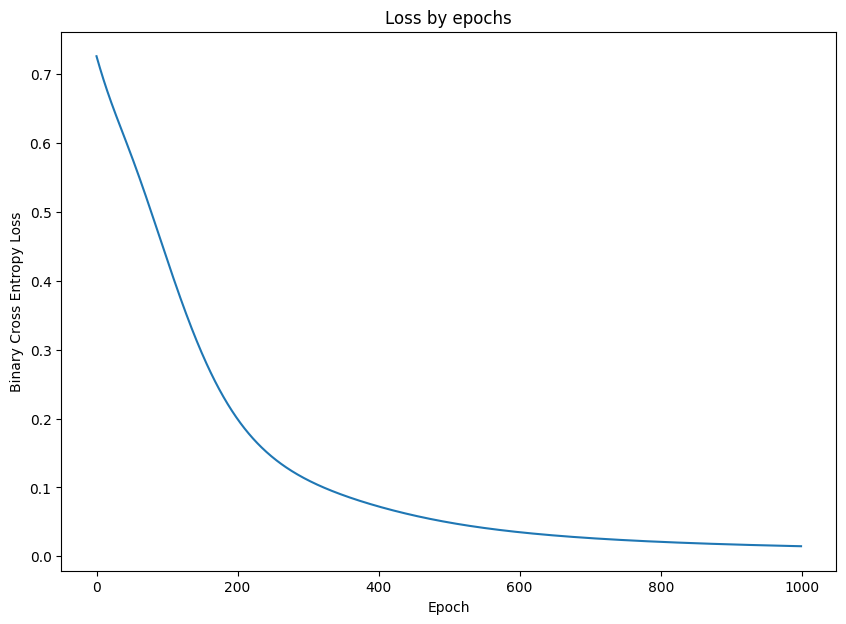

In [60]:
plt.figure(figsize=(10, 7))
plt.plot(history)

plt.title('Loss by epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.xlabel('Epoch')

plt.show()

In [61]:
from sklearn.metrics import classification_report
model.load_state_dict(torch.load('model.pth'))
y_pred = model(X_test).reshape(-1).to(torch.device('cpu'))
y_pred = y_pred.detach().numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        print(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4001
         1.0       0.93      1.00      0.96        80

    accuracy                           1.00      4081
   macro avg       0.97      1.00      0.98      4081
weighted avg       1.00      1.00      1.00      4081

Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0


In [62]:
import torch.optim as optim
from itertools import product
from sklearn.metrics import precision_score, recall_score

class GridSearch:

    def __init__(self, param_grid):
        self.best_score = 0
        self.best_params = None
        self.param_grid = param_grid
        self.best_estimator = None
    
    def fit(self, X_train=None, y_train=None, X_test=None, y_test=None, verbose=0):
        for epochs, lr, optimizer, hidden_layer_sizes, criterion in product(*self.param_grid.values()):
            if verbose > 0:
                print(f'epochs: {epochs}, lr: {lr}, optimizer: {optimizer}, hidden_layer_sizes: {hidden_layer_sizes}, criterion: {criterion}')
            
            model = Net(n_columns, 1, hidden_layer_sizes).to(device)
            criterion = criterion.to(device)
            optimizer = optimizer(model.parameters(), lr=lr)

            train_model(model, epochs, criterion, optimizer,"best_estimator.pth")
            
            y_pred = model(X_test).reshape(-1).to(torch.device('cpu')).detach().numpy()
            y_pred = np.where(y_pred > 0.5, 1, 0)

            accuracy = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            params = {
                    'epochs': epochs,
                    'lr': lr,
                    'optimizer': optimizer,
                    'hidden_layer_sizes': hidden_layer_sizes,
                    'criterion': criterion
                }
            
            if accuracy + recall > self.best_score:
                self.best_score = accuracy + recall
                self.best_params = params
                self.best_estimator = model





In [63]:

param_grid = {
    'epochs': [200, 500, 1000],
    'lr': [0.1, 0.01, 0.001, 0.0001],
    'optimizer': [optim.SGD, optim.Adam],
    'hidden_layer_sizes': [
        [8],
        [16, 2],
        [32, 16, 4, 2],

    ],
    'criterion': [nn.BCELoss()]
}

grid_search = GridSearch(param_grid)
grid_search.fit(X_train, y_train, X_test, y_test, verbose=1)

epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 90.00it/s, Loss=0.0854] 


epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 97.40it/s, Loss=0.119]


epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 81.85it/s, Loss=0.0964]


epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 1.000, prec: 0.976, rec: 1.000: 100%|██████████| 200/200 [00:02<00:00, 93.51it/s, Loss=0.00489]


epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 1.000, prec: 0.976, rec: 1.000: 100%|██████████| 200/200 [00:02<00:00, 91.06it/s, Loss=0.00423]


epochs: 200, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 88.57it/s, Loss=0.0965]


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 95.38it/s, Loss=0.293] 


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 94.03it/s, Loss=0.401]


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 93.78it/s, Loss=0.429]


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 93.21it/s, Loss=0.0191] 


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 95.48it/s, Loss=0.0186] 


epochs: 200, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 91.36it/s, Loss=0.241]


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 93.32it/s, Loss=0.486]


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 200/200 [00:02<00:00, 89.16it/s, Loss=0.73] 


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 88.18it/s, Loss=0.64] 


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 91.73it/s, Loss=0.169]


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 95.63it/s, Loss=0.0959]


epochs: 200, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 200/200 [00:02<00:00, 88.96it/s, Loss=0.855]


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.068, prec: 0.018, rec: 0.863: 100%|██████████| 200/200 [00:02<00:00, 85.90it/s, Loss=0.79] 


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 200/200 [00:02<00:00, 95.83it/s, Loss=1.02]


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 86.40it/s, Loss=0.563]


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.969, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 89.49it/s, Loss=0.63] 


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 90.01it/s, Loss=0.556]


epochs: 200, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 200/200 [00:02<00:00, 84.58it/s, Loss=0.464]


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 97.76it/s, Loss=0.0448] 


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 91.43it/s, Loss=0.0953]


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 89.46it/s, Loss=0.0931]


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 1.000, prec: 0.976, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 91.70it/s, Loss=0.00231]


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 90.28it/s, Loss=0.0965]


epochs: 500, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.999, prec: 0.964, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 86.56it/s, Loss=0.00207]


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 98.69it/s, Loss=0.17]  


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 94.09it/s, Loss=0.171]


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 91.09it/s, Loss=0.256]


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.999, prec: 0.930, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 90.31it/s, Loss=0.0139]


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.999, prec: 0.964, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 89.19it/s, Loss=0.0117]


epochs: 500, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 85.32it/s, Loss=0.116]


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 96.69it/s, Loss=0.436] 


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 91.44it/s, Loss=0.538] 


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 90.45it/s, Loss=0.382]


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.983, prec: 1.000, rec: 0.150: 100%|██████████| 500/500 [00:05<00:00, 90.23it/s, Loss=0.0473]


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 92.34it/s, Loss=0.0233]


epochs: 500, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 84.61it/s, Loss=0.0226]


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 98.27it/s, Loss=0.849] 


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 94.69it/s, Loss=0.874] 


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 89.59it/s, Loss=0.458]


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 90.85it/s, Loss=0.406]


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 500/500 [00:05<00:00, 92.93it/s, Loss=0.292]


epochs: 500, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 500/500 [00:05<00:00, 85.94it/s, Loss=1.02]


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 95.69it/s, Loss=0.032] 


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 91.67it/s, Loss=0.0759]


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:11<00:00, 87.53it/s, Loss=0.0841]


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.999, prec: 0.963, rec: 0.988: 100%|██████████| 1000/1000 [00:10<00:00, 93.14it/s, Loss=0.00119]


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.999, prec: 0.952, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 89.86it/s, Loss=0.00116]


epochs: 1000, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:11<00:00, 86.43it/s, Loss=0.0965]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 95.44it/s, Loss=0.102]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 94.58it/s, Loss=0.156]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:11<00:00, 88.29it/s, Loss=0.099]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.999, prec: 0.930, rec: 1.000: 100%|██████████| 1000/1000 [00:10<00:00, 91.90it/s, Loss=0.00931]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.999, prec: 0.952, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 89.52it/s, Loss=0.00835]


epochs: 1000, lr: 0.01, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.999, prec: 0.963, rec: 0.975: 100%|██████████| 1000/1000 [00:11<00:00, 84.63it/s, Loss=0.00705]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 93.25it/s, Loss=0.576]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 92.97it/s, Loss=0.358]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:11<00:00, 87.15it/s, Loss=0.375]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.998, prec: 0.899, rec: 1.000: 100%|██████████| 1000/1000 [00:10<00:00, 91.86it/s, Loss=0.0111]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.999, prec: 0.930, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 87.97it/s, Loss=0.00513]


epochs: 1000, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.999, prec: 0.930, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 85.18it/s, Loss=0.00305]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 1000/1000 [00:10<00:00, 95.89it/s, Loss=0.834]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 92.87it/s, Loss=0.547]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.sgd.SGD'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.020, prec: 0.020, rec: 1.000: 100%|██████████| 1000/1000 [00:11<00:00, 87.16it/s, Loss=1.02]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [8], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 94.43it/s, Loss=0.232]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [16, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:10<00:00, 91.18it/s, Loss=0.194]


epochs: 1000, lr: 0.0001, optimizer: <class 'torch.optim.adam.Adam'>, hidden_layer_sizes: [32, 16, 4, 2], criterion: BCELoss()


acc: 0.980, prec: 0.000, rec: 0.000: 100%|██████████| 1000/1000 [00:11<00:00, 85.64it/s, Loss=0.139]


In [81]:
grid_search.best_params

{'epochs': 200,
 'lr': 0.1,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.1
     maximize: False
     weight_decay: 0
 ),
 'hidden_layer_sizes': [8],
 'criterion': BCELoss()}

## Tuned model

In [82]:
best_model = grid_search.best_estimator.to('cuda')

y_pred = best_model(X_test).reshape(-1).to('cpu')
y_pred = y_pred.detach().numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)


print(classification_report(y_test, y_pred))
for i in range(len(y_pred)):
    if y_pred[i] != y_test[i]:
        print(f'Predicted: {y_pred[i]}, Actual: {y_test[i]}')



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4001
         1.0       0.98      1.00      0.99        80

    accuracy                           1.00      4081
   macro avg       0.99      1.00      0.99      4081
weighted avg       1.00      1.00      1.00      4081

Predicted: 1, Actual: 0.0
Predicted: 1, Actual: 0.0


In [83]:
import pandas as pd
data = pd.read_csv('task_1_verify.csv')
data

browser          os locale               location   
0             Firefox   Windows 7  xh-ZA           USA/New York  \
1              Chrome  Windows 10  pl-PL            Japan/Tokyo   
2             Firefox      Debian  vi-VN           France/Paris   
3             Firefox      Debian  en-US       Canada/Vancouver   
4             Firefox      Debian  en-CA       Australia/Sydney   
5             Firefox  Windows 10  en-AU              UK/London   
6              Safari   Windows 8  ru-RU         Canada/Toronto   
7             Firefox      Debian  nl-NL         Germany/Berlin   
8              Chrome  Windows 10  nl-NL       Australia/Sydney   
9             Firefox   Windows 7  xh-ZA   New Zealand/Auckland   
10             Chrome       MacOS  zh-CN           USA/New York   
11             Chrome      Ubuntu  en-NZ   New Zealand/Auckland   
12             Chrome       MacOS  fr-FR         China/Shanghai   
13            Firefox  Windows 10  en-GB           France/Paris   
14             Chrome  Windows 10  de-DE           France/Paris   
15            Firefox  Windows 10  en-US  Brazil/Rio de Janeiro   
16            Firefox  Windows 10  en-NZ   New Zealand/Auckland   
17            Firefox  Windows 10  fr-FR         China/Shanghai   
18            Firefox      Ubuntu  pt-PT         Germany/Berlin   
19  Internet Explorer       MacOS  ru-RU           France/Paris   
20             Chrome       MacOS  ur-PK              UK/London   
21            Firefox       MacOS  de-DE           Spain/Madrid   
22             Safari       MacOS  pt-BR  Netherlands/Amsterdam   
23  Internet Explorer  Windows 10  ru-RU          Russia/Moscow   
24            Firefox  Windows 10  ru-RU           France/Paris   
25             Safari  Windows 10  en-CA             Italy/Rome   
26  Internet Explorer       MacOS  ru-RU   New Zealand/Auckland   
27             Chrome       MacOS  uk-UA  Netherlands/Amsterdam   
28            Firefox  Windows 10  uk-UA            India/Delhi   
29             Safari  Windows 10  en-US   New Zealand/Auckland   
30            Firefox  Windows 10  xh-ZA   New Zealand/Auckland   
31            Firefox      Ubuntu  ru_RU            USA/Chicago   
32             Chrome  Windows 10  ru_RU            USA/Chicago   
33            Firefox  Windows 10  ru_RU            USA/Chicago   
34             Chrome      Ubuntu  ru_RU            USA/Chicago   
35             Chrome  Windows 10  ru_RU            USA/Chicago   

                                                sites      time        date  
0   [{'site': 'rr.office.microsoft.com', 'length':...  11:30:00  2016-10-05  
1   [{'site': 'maps.google.com', 'length': 14}, {'...  14:35:00  2016-05-06  
2   [{'site': 'cbk1.googleapis.com', 'length': 178...  14:31:00  2016-03-27  
3   [{'site': 'annotathon.org', 'length': 72}, {'s...  10:55:00  2016-12-31  
4   [{'site': 'apis.google.com', 'length': 75}, {'...  03:30:00  2017-01-19  
5   [{'site': 'plus.google.com', 'length': 125}, {...  10:06:00  2016-02-20  
6   [{'site': 'translate.google.com', 'length': 88...  13:05:00  2017-07-25  
7   [{'site': 'apis.google.com', 'length': 89}, {'...  02:16:00  2017-02-27  
8   [{'site': 'cbks0.google.com', 'length': 92}, {...  21:13:00  2016-07-31  
9   [{'site': 'ec.gc.ca', 'length': 25}, {'site': ...  10:59:00  2016-07-12  
10  [{'site': 'clients1.google.fr', 'length': 168}...  02:00:00  2016-07-23  
11  [{'site': 'twitter.com', 'length': 117}, {'sit...  10:49:00  2017-03-20  
12  [{'site': 'www.google.com', 'length': 54}, {'s...  13:59:00  2016-03-06  
13  [{'site': 'apnx-match.dotomi.com', 'length': 4...  00:58:00  2017-06-21  
14  [{'site': 'www.fff.fr', 'length': 124}, {'site...  02:52:00  2017-06-18  
15  [{'site': 'worldcup-in-brazil.com', 'length': ...  18:27:00  2016-11-02  
16  [{'site': 'ieonline.microsoft.com', 'length': ...  11:54:00  2017-04-21  
17  [{'site': 'meta.wikimedia.org', 'length': 125}...  22:34:00  2016-03-17  
18  [{'site': 'www.radiorva.com', 'length': 191}, ..

In [84]:
preprocess(data)
print(categorical)
data.head()

['browser', 'os', 'locale', 'city', 'country']


browser          os locale       city    country  year  month  day    sec
0  Firefox   Windows 7  xh-ZA   New York        USA  2016     10    5  41400
1   Chrome  Windows 10  pl-PL      Tokyo      Japan  2016      5    6  52500
2  Firefox      Debian  vi-VN      Paris     France  2016      3   27  52260
3  Firefox      Debian  en-US  Vancouver     Canada  2016     12   31  39300
4  Firefox      Debian  en-CA     Sydney  Australia  2017      1   19  12600

In [85]:
data_cat_ohe = pd.DataFrame(ohe.transform(data[categorical]), columns=ohe.get_feature_names_out(categorical))
data = data.drop(categorical, axis=1)

data_cat_ohe.index = data.index

data[ohe.get_feature_names_out(categorical)] = data_cat_ohe
data


year  month  day    sec  browser_Chrome  browser_Firefox   
0   2016     10    5  41400             0.0              1.0  \
1   2016      5    6  52500             1.0              0.0   
2   2016      3   27  52260             0.0              1.0   
3   2016     12   31  39300             0.0              1.0   
4   2017      1   19  12600             0.0              1.0   
5   2016      2   20  36360             0.0              1.0   
6   2017      7   25  47100             0.0              0.0   
7   2017      2   27   8160             0.0              1.0   
8   2016      7   31  76380             1.0              0.0   
9   2016      7   12  39540             0.0              1.0   
10  2016      7   23   7200             1.0              0.0   
11  2017      3   20  38940             1.0              0.0   
12  2016      3    6  50340             1.0              0.0   
13  2017      6   21   3480             0.0              1.0   
14  2017      6   18  10320             1.0              0.0   
15  2016     11    2  66420             0.0              1.0   
16  2017      4   21  42840             0.0              1.0   
17  2016      3   17  81240             0.0              1.0   
18  2017      3   30   4500             0.0              1.0   
19  2016     11   18  21300             0.0              0.0   
20  2016     10    1  19260             1.0              0.0   
21  2016      4   17  73260             0.0              1.0   
22  2016      9   11  23040             0.0              0.0   
23  2016      5    5  16020             0.0              0.0   
24  2016      8   20  28020             0.0              1.0   
25  2017      2   22  40860             0.0              0.0   
26  2017      7   28   3300             0.0              0.0   
27  2017      6    8  26220             1.0              0.0   
28  2017      6    4   7380             0.0              1.0   
29  2016     10   10  21660             0.0              0.0   
30  2016     11   23  54480             0.0              1.0   
31  2017      5    9  66420             0.0              1.0   
32  2016     11    8   9360             1.0              0.0   
33  2016     10   27  10500             0.0              1.0   
34  2016     11   25  64260             1.0              0.0   
35  2016     12   18  63840             1.0              0.0   

    browser_Internet Explorer  browser_Safari  os_Debian  os_MacOS  ...   
0                         0.0             0.0        0.0       0.0  ...  \
1                         0.0             0.0        0.0       0.0  ...   
2                         0.0             0.0        1.0       0.0  ...   
3                         0.0             0.0        1.0       0.0  ...   
4                         0.0             0.0        1.0       0.0  ...   
5                         0.0             0.0        0.0       0.0  ...   
6                         0.0             1.0        0.0       0.0  ...   
7                         0.0             0.0        1.0       0.0  ...   
8                         0.0             0.0        0.0       0.0  ...   
9                         0.0             0.0        0.0       0.0  ...   
10                        0.0             0.0        0.0       1.0  ...   
11                        0.0             0.0        0.0       0.0  ...   
12                        0.0             0.0        0.0       1.0  ...   
13                        0.0             0.0        0.0       0.0  ...   
14                        0.0             0.0        0.0       0.0  ...   
15                        0.0             0.0        0.0       0.0  ...   
16                        0.0             0.0        0.0       0.0  ...   
17                        0.0             0.0        0.0       0.0  ...   
18                        0.0             0.0        0.0       0.0  ...   
19                        1.0             0.0        0.0       1.0  ...   
20                        0.0             0.0        0.0    

In [86]:
from feature_engine.creation import CyclicalFeatures
from sklearn.preprocessing import StandardScaler

data = cyclical.transform(data)

data['year'] = scaler.transform(data[['year']])
data

year  browser_Chrome  browser_Firefox  browser_Internet Explorer   
0  -0.840900             0.0              1.0                        0.0  \
1  -0.840900             1.0              0.0                        0.0   
2  -0.840900             0.0              1.0                        0.0   
3  -0.840900             0.0              1.0                        0.0   
4   1.189202             0.0              1.0                        0.0   
5  -0.840900             0.0              1.0                        0.0   
6   1.189202             0.0              0.0                        0.0   
7   1.189202             0.0              1.0                        0.0   
8  -0.840900             1.0              0.0                        0.0   
9  -0.840900             0.0              1.0                        0.0   
10 -0.840900             1.0              0.0                        0.0   
11  1.189202             1.0              0.0                        0.0   
12 -0.840900             1.0              0.0                        0.0   
13  1.189202             0.0              1.0                        0.0   
14  1.189202             1.0              0.0                        0.0   
15 -0.840900             0.0              1.0                        0.0   
16  1.189202             0.0              1.0                        0.0   
17 -0.840900             0.0              1.0                        0.0   
18  1.189202             0.0              1.0                        0.0   
19 -0.840900             0.0              0.0                        1.0   
20 -0.840900             1.0              0.0                        0.0   
21 -0.840900             0.0              1.0                        0.0   
22 -0.840900             0.0              0.0                        0.0   
23 -0.840900             0.0              0.0                        1.0   
24 -0.840900             0.0              1.0                        0.0   
25  1.189202             0.0              0.0                        0.0   
26  1.189202             0.0              0.0                        1.0   
27  1.189202             1.0              0.0                        0.0   
28  1.189202             0.0              1.0                        0.0   
29 -0.840900             0.0              0.0                        0.0   
30 -0.840900             0.0              1.0                        0.0   
31  1.189202             0.0              1.0                        0.0   
32 -0.840900             1.0              0.0                        0.0   
33 -0.840900             0.0              1.0                        0.0   
34 -0.840900             1.0              0.0                        0.0   
35 -0.840900             1.0              0.0                        0.0   

    browser_Safari  os_Debian  os_MacOS  os_Ubuntu  os_Windows 10   
0              0.0        0.0       0.0        0.0            0.0  \
1              0.0        0.0       0.0        0.0            1.0   
2              0.0        1.0       0.0        0.0            0.0   
3              0.0        1.0       0.0        0.0            0.0   
4              0.0        1.0       0.0        0.0            0.0   
5              0.0        0.0       0.0        0.0            1.0   
6              1.0        0.0       0.0        0.0            0.0   
7              0.0        1.0       0.0        0.0            0.0   
8              0.0        0.0       0.0        0.0            1.0   
9              0.0        0.0       0.0        0.0            0.0   
10             0.0        0.0       1.0        0.0            0.0   
11             0.0        0.0       0.0        1.0            0.0   
12             0.0        0.0       1.0        0.0            0.0   
13             0.0        0.0       0.0        0.0            1.0   
14             0.0        0.0       0.0        0.0            1.0   
15             0.0        0.0       0.0        0.0            1.0   
16             0.0    

In [88]:
data = torch.tensor(data.values, dtype=torch.float32).to('cuda')

y_pred = best_model(data).reshape(-1).to('cpu')
y_pred = y_pred.detach().numpy()
y_pred = np.where(y_pred > 0.5, 1, 0)

pd.DataFrame(y_pred, columns=['is_waldo'])

is_waldo
0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         1
32         1
33         1
34         1
35         1

### Questions
1. Did you find any usefull insights from your data analysis?
    - Highly correlated features:
    browser: Firefox or Chrome
    os: Windows 10 or Ubuntu
    locale: ru_RU
    city: Toronto, Chicago or Paris
    country: Canada, USA, France
    
    - No outliers, missing values in dataset
    - dataset is imbalanced

2. What preprocessing techniques did you use? Why?
    - For numerical features the Cyclical Transform is applied to data with cyclical patterns, such as months, days, or time in seconds, because it maps these features onto a circle, preserving their cyclic nature and enabling algorithms to better capture their patterns. Standard Scaling is used for the year feature because it rescales the data to have a mean of zero and a standard deviation of one, which can help to normalize the data.
    - For categorical features, I have used OHE (One-Hot Encoding) because it provides a simple and more effective than label or count encoding

3. Describe the fine-tuning process and how you reached your model architecture.
    - Using the grid search I wrote, I went through the following hyperparameters: the number of epochs to train the model for (epochs), the learning rate for the optimizer (lr), the optimizer to use (optimizer), the sizes of the hidden layers (hidden_layer_sizes), and the criterion to optimize during training (criterion).
4. Which metric did you try to optemize for this task? Why?
    - recall is more imporant to this task, because correctly identifying all positive instances is more important than avoiding false positives (incorrectly predicted positive instances), but since it wasn't hard to achieve recall= 1, i tried to optimize both recall and precision.

# Task 2: Fingerprint Recognition (50 points)
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

In this task you will be doing a simplified version of Fingerprint ID, which is just identifying which finger is used in the image

## What you need to do

For this task, you will be doing image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

For the given data, you need to do proper data preprocessing, augmentation, and data loaders.

Then fine-tune your model architecture to achieve the highest accuracy.

### Learning Objectives

- Select and implement suitable data preprocessing techniques. 10%
- Use literature (any paper on the use of CNN for fingerprinting and cite it) to choose an architecture. 10%
- Apply CNNs to solve an image classification problem (basic training, validation, testing -- without fine tuning). 40%
- Fine-tune your model to improve performance. 20%
- Use of data augmentation to improve model’s performance. 20%
- Explore beyond data augmentation find techniques to improve model’s performance and use them. 15%(bonus)


### Data
[Download link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

You will be working with the data in `task_2.zip` for identifying. The name of each image consists of 2 parts like
`idx_label.BMB`

Where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

https://www.researchgate.net/publication/359366490_Fingerprint_classification_system_using_CNN

![](lenet-5.png)

In [146]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageFolder(root='train', transform=transform)
testset = ImageFolder(root='test', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

train_size, val_size


(15530, 3883)

(96, 96, 1)


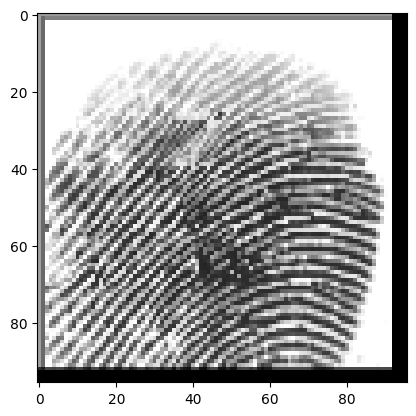

In [147]:
import matplotlib.pyplot as plt
import numpy as np

img, labels = dataset[0]
img = img.numpy()
image = np.transpose(img*0.5+0.5, (1, 2, 0))
print(image.shape)
plt.imshow(image, cmap='gray')
plt.show()


Datasets are balanced

In [148]:
mp_train = {i: 0 for i in range(10)}
mp_test = {i: 0 for i in range(10)}

for element, label in dataset:
    mp_train[label] += 1

for element, label in testset:
    mp_test[label] += 1

mp_train, mp_test

({0: 1950,
  1: 1921,
  2: 1950,
  3: 1952,
  4: 1949,
  5: 1941,
  6: 1940,
  7: 1938,
  8: 1946,
  9: 1926},
 {0: 1617,
  1: 1415,
  2: 1479,
  3: 1498,
  4: 1372,
  5: 1467,
  6: 1305,
  7: 1369,
  8: 1406,
  9: 1344})

In [149]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    
    def __init__(self, num_classes=10, dropout=0.1, fc1_size= 120, fc2_size=84):
        super(LeNet, self).__init__()
        #1x96x96 -> 6x21x21
        self.features = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 21 * 21, fc1_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(fc1_size, fc2_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(fc2_size, num_classes),
        )
        
    def forward(self, x):
        x = self.features(x)
        # flatten the output of conv2 to (batch_size, 16 * 21 * 21)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.softmax(x, dim=1)

In [150]:
device = torch.device('cpu')

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
device

device(type='cuda')

In [151]:
classes = 10
epochs = 20
batch_size = 128
learning_rate = 0.001

model = LeNet(num_classes=classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


In [152]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

print(f'iterations: {len(trainloader)}')
print(f'iterations: {len(validationloader)}')

for epoch in (bar := tqdm(range(epochs))):
    i = 0
    for images, labels in trainloader:  
    
        images = images.to(device)
        labels = labels.to(device)
        
    
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_postfix({'it': i/ len(trainloader), 'Loss': loss.item()})
        i += 1
        
    with torch.no_grad():
        y_pred = np.array([])
        y_test = np.array([])

        for images, labels in validationloader:
            images = images.to(device)
            
            out = model(images)
            predicted = torch.argmax(out, dim=1).to('cpu').numpy()
            y_pred = np.concatenate((y_pred, predicted))
            y_test = np.concatenate((y_test, labels))
        
        bar.set_description(f'acc: {accuracy_score(y_test, y_pred)}')

                


iterations: 121
iterations: 30


acc: 0.83203125: 100%|██████████| 20/20 [03:39<00:00, 10.95s/it, it=0.992, Loss=1.58]          


In [153]:
from sklearn.metrics import classification_report

testloader = DataLoader(testset, batch_size=64, shuffle=False)
y_pred = np.array([])
y_test = np.array([])

for images, labels in testloader:
    images = images.to(device)
     
    out = model(images)
    predicted = torch.argmax(out, dim=1).to('cpu').numpy()
    y_pred = np.concatenate((y_pred, predicted))
    y_test = np.concatenate((y_test, labels))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.71      0.75      1617
         1.0       0.79      0.53      0.63      1415
         2.0       0.59      0.72      0.65      1479
         3.0       0.52      0.78      0.62      1498
         4.0       0.71      0.30      0.43      1372
         5.0       0.79      0.78      0.79      1467
         6.0       0.72      0.66      0.69      1305
         7.0       0.72      0.69      0.70      1369
         8.0       0.54      0.79      0.64      1406
         9.0       0.70      0.65      0.67      1344

    accuracy                           0.66     14272
   macro avg       0.69      0.66      0.66     14272
weighted avg       0.69      0.66      0.66     14272



## Data augmentation

In [154]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

aug_dataset = ImageFolder(root='train', transform=transform)

dataset += aug_dataset

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

train_size, val_size

(31060, 7766)

## GridSearch

In [155]:
from itertools import product
from sklearn.metrics import precision_score, recall_score
import gc

class GridSearch:

    def __init__(self, param_grid):
        self.best_score = 0
        self.best_params = None
        self.param_grid = param_grid
        self.best_estimator = None

    def train(self, epochs, trainloader, device, model, criterion, optimizer):
        for epoch in (bar:=tqdm(range(epochs))):
            for images, labels in trainloader:  
            
                images = images.to(device)
                labels = labels.to(device)
                
            
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    
    def test(self, batch_size, epochs, lr, optimizer, fc1_size, fc2_size, criterion, dropout, validationloader, model):
        with torch.no_grad():
            y_pred = np.array([])
            y_test = np.array([])
            
            for images, labels in validationloader:
                images = images.to(device)
                
                out = model(images)
                predicted = torch.argmax(out, dim=1).to('cpu').numpy()
                y_pred = np.concatenate((y_pred, predicted))
                y_test = np.concatenate((y_test, labels))

            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            print(f'acc: {accuracy_score(y_test, y_pred)}')
            params = {
                'batch_size': batch_size,
                'epochs': epochs,
                'lr': lr,
                'optimizer': optimizer,
                'fc1_size': fc1_size,
                'fc2_size': fc2_size,
                'criterion': criterion,
                'dropout': dropout
                }
            
            if precision + recall > self.best_score:
                self.best_score = precision + recall
                self.best_params = params
                self.best_estimator = model


    
    def fit(self, train_dataset=None, validation_dataset=None, X_test=None, y_test=None, verbose=0):
        for batch_size, epochs, lr, optimizer, fc_size, criterion, dropout in product(*self.param_grid.values()):
            if verbose > 0:
                print(f'batch_size: {batch_size}, epochs: {epochs}, lr: {lr}, optimizer: {optimizer}, fc1_size: {fc_size[0]}, fc2_size: {fc_size[1]}, criterion: {criterion}, droput: {dropout}')
            
            model = LeNet(num_classes=classes, fc1_size=fc_size[0], fc2_size=fc_size[1], dropout=dropout).to(device)
            criterion = criterion.to(device)
            optimizer = optimizer(model.parameters(), lr=lr)
            
            trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
            validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

            self.train(epochs, trainloader, device, model, criterion, optimizer)
            self.test(batch_size, epochs, lr, optimizer, fc_size[0], fc_size[1], criterion, dropout, validationloader, model)
            gc.collect()
            torch.cuda.empty_cache()

In [156]:
# define the grid search parameters
import torch.optim as optim
param_grid = {
    'batch_size': [64, 128],
    'epochs': [20],
    'lr': [0.001, 0.1, 0.01],
    'optimizer': [optim.Adam, optim.SGD],
    'fc_size': [[120, 84], [256, 128]],
    'criterion': [nn.CrossEntropyLoss()],
    'dropout_rate':[0.2, 0.3]
}

grid_search = GridSearch(param_grid)
grid_search.fit(train_dataset, validation_dataset, X_test, y_test, verbose=1)

batch_size: 128, epochs: 20, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 120, fc2_size: 84, criterion: CrossEntropyLoss(), droput: 0.2


100%|██████████| 20/20 [05:44<00:00, 17.24s/it]


acc: 0.873828125
batch_size: 128, epochs: 20, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 120, fc2_size: 84, criterion: CrossEntropyLoss(), droput: 0.3


100%|██████████| 20/20 [05:36<00:00, 16.82s/it]


acc: 0.7893229166666667
batch_size: 128, epochs: 20, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 256, fc2_size: 128, criterion: CrossEntropyLoss(), droput: 0.2


100%|██████████| 20/20 [05:34<00:00, 16.71s/it]


acc: 0.8932291666666666
batch_size: 128, epochs: 20, lr: 0.001, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 256, fc2_size: 128, criterion: CrossEntropyLoss(), droput: 0.3


100%|██████████| 20/20 [05:34<00:00, 16.72s/it]


acc: 0.8688802083333333
batch_size: 128, epochs: 20, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 120, fc2_size: 84, criterion: CrossEntropyLoss(), droput: 0.2


100%|██████████| 20/20 [05:39<00:00, 16.97s/it]
c:\Users\hir0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc: 0.09908854166666667
batch_size: 128, epochs: 20, lr: 0.1, optimizer: <class 'torch.optim.adam.Adam'>, fc1_size: 120, fc2_size: 84, criterion: CrossEntropyLoss(), droput: 0.3


 65%|██████▌   | 13/20 [03:52<02:05, 17.86s/it]


KeyboardInterrupt: 

In [157]:
grid_search.best_params

{'batch_size': 128,
 'epochs': 20,
 'lr': 0.001,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'fc1_size': 256,
 'fc2_size': 128,
 'criterion': CrossEntropyLoss(),
 'dropout': 0.2}

## Tuned model
let's train the best model on a large number of epochs

In [158]:
classes = 10
epochs = 100
batch_size = 128
learning_rate = 0.001

model = LeNet(num_classes=classes, fc1_size=256, fc2_size=128, dropout=0.2).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validationloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [159]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

print(f'iterations: {len(trainloader)}')
print(f'iterations: {len(validationloader)}')

for epoch in (bar := tqdm(range(epochs))):
    i = 0
    for images, labels in trainloader:  
    
        images = images.to(device)
        labels = labels.to(device)
        
    
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bar.set_postfix({'it': i/ len(trainloader), 'Loss': loss.item()})
        i += 1
        
    with torch.no_grad():
        y_pred = np.array([])
        y_test = np.array([])

        for images, labels in validationloader:
            images = images.to(device)
            
            out = model(images)
            predicted = torch.argmax(out, dim=1).to('cpu').numpy()
            y_pred = np.concatenate((y_pred, predicted))
            y_test = np.concatenate((y_test, labels))
        
        bar.set_description(f'acc: {accuracy_score(y_test, y_pred)}')

                


iterations: 242
iterations: 60


acc: 0.9645833333333333: 100%|██████████| 100/100 [46:02<00:00, 27.63s/it, it=0.996, Loss=1.48] 


In [160]:
from sklearn.metrics import classification_report

testloader = DataLoader(testset, batch_size=64, shuffle=False)
y_pred = np.array([])
y_test = np.array([])

for images, labels in testloader:
    images = images.to(device)
     
    out = model(images)
    predicted = torch.argmax(out, dim=1).to('cpu').numpy()
    y_pred = np.concatenate((y_pred, predicted))
    y_test = np.concatenate((y_test, labels))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.91      0.89      1617
         1.0       0.83      0.87      0.85      1415
         2.0       0.94      0.74      0.83      1479
         3.0       0.90      0.80      0.84      1498
         4.0       0.77      0.89      0.82      1372
         5.0       0.90      0.92      0.91      1467
         6.0       0.83      0.92      0.87      1305
         7.0       0.81      0.90      0.85      1369
         8.0       0.89      0.82      0.86      1406
         9.0       0.90      0.83      0.87      1344

    accuracy                           0.86     14272
   macro avg       0.86      0.86      0.86     14272
weighted avg       0.87      0.86      0.86     14272



### Questions
1. What preprocessing techniques did you use? Why?
    - Resize, because we have to standardize the input image sizes so that they can be processed efficiently by the cnn model.
    - Grayscale, because images already in black-white and also to reduce the computational load. 
    - Normalize, because it make images easier to process and improve the performance of the model.

2. What data augmentation techniques did you use?
    - ColorJitter, because it involves randomly adjusting the brightness, contrast, saturation, and hue of an image to create new variations of the original image. By this augmentation I have increased the size of dataset twice.
3. Describe the fine-tuning process and how you reached your final CNN model.
    - By using class GridSearch written by me, I iterated over different hyperparameters: batch size, epochs, learning rate, optimizer, sizes of fully connected layer, criterion, dropout rate.
4. What techniques did you use to improve model’s performance other than data augmentation
   - Model architecture optimization: dropout layers, batch normalization layers.

# Task 3: Credit approval (15 points)

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## What you need to do

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Learning Objectives

- Apply DTs, and RFs to solve a classification problem (basic training, validation, testing. 50%
- Fine-tune to determine the optimal model architecture. 20%
- Evaluate and compare the performance of different models. 10%
- Visualise the models. 20%


### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [174]:
import pandas as pd
df = pd.read_csv('loan_data.csv')
df

credit.policy             purpose  int.rate  installment   
0                 1  debt_consolidation    0.1189       829.10  \
1                 1         credit_card    0.1071       228.22   
2                 1  debt_consolidation    0.1357       366.86   
3                 1  debt_consolidation    0.1008       162.34   
4                 1         credit_card    0.1426       102.92   
...             ...                 ...       ...          ...   
9573              0           all_other    0.1461       344.76   
9574              0           all_other    0.1253       257.70   
9575              0  debt_consolidation    0.1071        97.81   
9576              0    home_improvement    0.1600       351.58   
9577              0  debt_consolidation    0.1392       853.43   

      log.annual.inc    dti  fico  days.with.cr.line  revol.bal  revol.util   
0          11.350407  19.48   737        5639.958333      28854        52.1  \
1          11.082143  14.29   707        2760.000000      33623        76.7   
2          10.373491  11.63   682        4710.000000       3511        25.6   
3          11.350407   8.10   712        2699.958333      33667        73.2   
4          11.299732  14.97   667        4066.000000       4740        39.5   
...              ...    ...   ...                ...        ...         ...   
9573       12.180755  10.39   672       10474.000000     215372        82.1   
9574       11.141862   0.21   722        4380.000000        184         1.1   
9575       10.596635  13.09   687        3450.041667      10036        82.9   
9576       10.819778  19.18   692        1800.000000          0         3.2   
9577       11.264464  16.28   732        4740.000000      37879        57.0   

      inq.last.6mths  delinq.2yrs  pub.rec  not.fully.paid  
0                  0            0        0               0  
1                  0            0        0               0  
2                  1            0        0               0  
3                  1            0        0               0  
4                  0            1        0               0  
...              ...          ...      ...             ...  
9573               2            0        0               1  
9574               5            0        0               1  
9575               8            0        0               1  
9576               5            0        0               1  
9577               6            0        0               1  

[9578 rows x 14 columns]

In [175]:
numerical = df.columns[df.dtypes != 'object'].drop('credit.policy')
categorical = df.columns[df.dtypes == 'object']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [176]:
#number of unique values in each column
df.nunique()


credit.policy           2
purpose                 7
int.rate              249
installment          4788
log.annual.inc       1987
dti                  2529
fico                   44
days.with.cr.line    2687
revol.bal            7869
revol.util           1035
inq.last.6mths         28
delinq.2yrs            11
pub.rec                 6
not.fully.paid          2
dtype: int64

No missing valeus in dataset

In [177]:
df.isna().sum()

credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Dataset is imbalanced

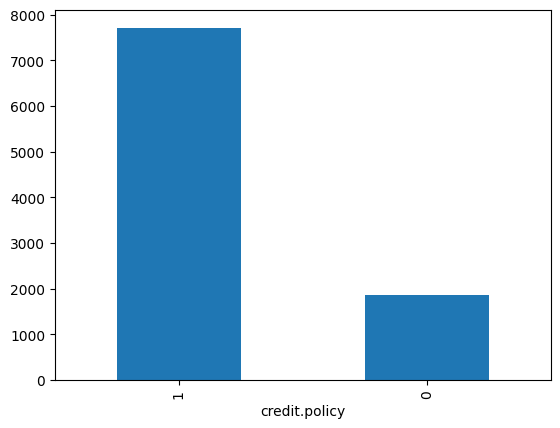

In [178]:
df['credit.policy'].value_counts().plot(kind='bar')
plt.show()

In [179]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('credit.policy', axis=1), df['credit.policy'], test_size=0.2, stratify=df['credit.policy'])


## Train
Encode categorical features.

In [180]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_cat_ohe = pd.DataFrame(ohe.fit_transform(X_train[categorical]), columns=ohe.get_feature_names_out(categorical))
X_train = X_train.drop(categorical, axis=1)

X_train_cat_ohe.index = X_train.index

X_train[ohe.get_feature_names_out(categorical)] = X_train_cat_ohe
X_train

int.rate  installment  log.annual.inc    dti  fico  days.with.cr.line   
2211    0.1189       215.57        9.952278   8.57   722        3210.041667  \
7905    0.1438       359.95       11.225243  13.07   657        2429.958333   
8403    0.1261       536.11       11.567414  19.23   687        5040.041667   
8490    0.1324       148.77       10.524064  18.04   662        3900.000000   
9313    0.1322        67.61       10.596635  24.54   677        3720.000000   
...        ...          ...             ...    ...   ...                ...   
8448    0.1166        82.64       10.395130  20.33   687        2370.000000   
213     0.1091       604.88       10.858999  17.56   707        8061.000000   
2428    0.1568       420.02       11.289782  14.21   672        4470.000000   
3812    0.1221       333.15       10.714418   0.00   707        2640.000000   
5837    0.0894       317.72       11.492723  15.86   747        7230.000000   

      revol.bal  revol.util  inq.last.6mths  delinq.2yrs  pub.rec   
2211       9317        53.6               1            0        0  \
7905      22764        39.7               1            0        0   
8403     111115        40.8               4            1        0   
8490       1085        57.5               6            0        1   
9313       2622        24.3               5            0        0   
...         ...         ...             ...          ...      ...   
8448         15         0.4               6            0        0   
213       32438        43.0               0            1        0   
2428       8664        93.2               1            0        0   
3812       4924        23.8               0            1        0   
5837      32508        40.8               1            0        0   

      not.fully.paid  purpose_all_other  purpose_credit_card   
2211               1                0.0                  0.0  \
7905               0                0.0                  0.0   
8403               0                0.0                  0.0   
8490               1                0.0                  0.0   
9313               0                0.0                  0.0   
...              ...                ...                  ...   
8448               0                1.0                  0.0   
213                0                0.0                  1.0   
2428               0                0.0                  0.0   
3812               0                1.0                  0.0   
5837               0                0.0                  0.0   

      purpose_debt_consolidation  purpose_educational   
2211                         1.0                  0.0  \
7905                         1.0                  0.0   
8403                         0.0                  0.0   
8490                         0.0                  0.0   
9313                         1.0                  0.0   
...                          ...                  ...   
8448                         0.0                  0.0   
213                          0.0                  0.0   
2428                         1.0                  0.0   
3812                         0.0                  0.0   
5837                         1.0                  0.0   

      purpose_home_improvement  purpose_major_purchase  purpose_small_business  
2211                       0.0                     0.0                     0.0  
7905                       0.0                     0.0                     0.0  
8403                       0.0                     1.0                     0.0  
8490                       0.0                     1.0                     0.0  
9313                       0.0                     0.0                     0.0  
...                        ...                     ...                     ...  
8448                       0.0                     0.0                     0.0  
213                        0.0                     0.0                     0.0  
2428                       0.0               

Encode numerical features.

In [181]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_train

int.rate  installment  log.annual.inc       dti      fico   
2211  0.376598     0.216215        0.344482  0.286048  0.523810  \
7905  0.535806     0.372394        0.526833  0.436248  0.214286   
8403  0.422634     0.562951        0.575848  0.641856  0.357143   
8490  0.462916     0.143956        0.426390  0.602136  0.238095   
9313  0.461637     0.056163        0.436785  0.819092  0.309524   
...        ...          ...             ...       ...       ...   
8448  0.361893     0.072421        0.407920  0.678571  0.357143   
213   0.313939     0.637341        0.474369  0.586115  0.452381   
2428  0.618926     0.437374        0.536078  0.474299  0.285714   
3812  0.397059     0.343404        0.453657  0.000000  0.452381   
5837  0.187980     0.326713        0.565149  0.529372  0.642857   

      days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs   
2211           0.173592   0.009787    0.450420        0.030303     0.000000  \
7905           0.128916   0.023911    0.333613        0.030303     0.000000   
8403           0.278397   0.116716    0.342857        0.121212     0.076923   
8490           0.213106   0.001140    0.483193        0.181818     0.000000   
9313           0.202797   0.002754    0.204202        0.151515     0.000000   
...                 ...        ...         ...             ...          ...   
8448           0.125482   0.000016    0.003361        0.181818     0.000000   
213            0.451408   0.034073    0.361345        0.000000     0.076923   
2428           0.245750   0.009101    0.783193        0.030303     0.000000   
3812           0.140945   0.005172    0.200000        0.000000     0.076923   
5837           0.403817   0.034147    0.342857        0.030303     0.000000   

      pub.rec  not.fully.paid  purpose_all_other  purpose_credit_card   
2211      0.0             1.0                0.0                  0.0  \
7905      0.0             0.0                0.0                  0.0   
8403      0.0             0.0                0.0                  0.0   
8490      0.2             1.0                0.0                  0.0   
9313      0.0             0.0                0.0                  0.0   
...       ...             ...                ...                  ...   
8448      0.0             0.0                1.0                  0.0   
213       0.0             0.0                0.0                  1.0   
2428      0.0             0.0                0.0                  0.0   
3812      0.0             0.0                1.0                  0.0   
5837      0.0             0.0                0.0                  0.0   

      purpose_debt_consolidation  purpose_educational   
2211                         1.0                  0.0  \
7905                         1.0                  0.0   
8403                         0.0                  0.0   
8490                         0.0                  0.0   
9313                         1.0                  0.0   
...                          ...                  ...   
8448                         0.0                  0.0   
213                          0.0                  0.0   
2428                         1.0                  0.0   
3812                         0.0                  0.0   
5837                         1.0                  0.0   

      purpose_home_improvement  purpose_major_purchase  purpose_small_business  
2211                       0.0                     0.0                     0.0  
7905                       0.0                     0.0                     0.0  
8403                       0.0                     1.0                     0.0  
8490                       0.0                     1.0                     0.0  
9313                       0.0                     0.0                     0.0  
...                        ...                     ...                     ...  
8448                       0.0                     0.0                     0.0  
213                        0.0            

## Test

In [182]:
X_test_cat_ohe = pd.DataFrame(ohe.transform(X_test[categorical]), columns=ohe.get_feature_names_out(categorical))
X_test = X_test.drop(categorical, axis=1)

X_test_cat_ohe.index = X_test.index

X_test[ohe.get_feature_names_out(categorical)] = X_test_cat_ohe
X_test

int.rate  installment  log.annual.inc    dti  fico  days.with.cr.line   
9391    0.1843       363.70       11.050890  15.58   717        5348.041667  \
7584    0.1062        97.68       10.463103   8.91   692        6090.041667   
8508    0.1861       535.95       11.007419  24.29   657        3180.000000   
377     0.1014       485.00       11.338572  19.86   742        2763.041667   
3991    0.2011       623.40       11.002100  21.34   662        3960.000000   
...        ...          ...             ...    ...   ...                ...   
4785    0.1253       334.67       10.596635  20.46   702        2520.000000   
33      0.0807        78.42       11.608236  11.33   762        6059.958333   
7463    0.1422       617.12       11.141862  17.57   682        3121.041667   
7202    0.0714        30.94       10.839581  16.99   762        5580.041667   
567     0.1008       129.22       10.385914  16.26   717        1560.000000   

      revol.bal  revol.util  inq.last.6mths  delinq.2yrs  pub.rec   
9391      18157        69.6              10            0        0  \
7584      12509        37.1               2            1        0   
8508      28890        72.0               1            0        0   
377        6437        28.6               4            0        0   
3991      13337        59.0               0            1        1   
...         ...         ...             ...          ...      ...   
4785       7722        66.1               0            0        0   
33         7274        13.1               0            0        0   
7463      26364        57.8               0            0        0   
7202        737         7.8               1            0        0   
567        2352        27.3               1            0        0   

      not.fully.paid  purpose_all_other  purpose_credit_card   
9391               0                0.0                  1.0  \
7584               1                1.0                  0.0   
8508               0                0.0                  0.0   
377                0                1.0                  0.0   
3991               1                0.0                  0.0   
...              ...                ...                  ...   
4785               1                0.0                  0.0   
33                 0                0.0                  0.0   
7463               0                0.0                  0.0   
7202               0                0.0                  0.0   
567                0                0.0                  0.0   

      purpose_debt_consolidation  purpose_educational   
9391                         0.0                  0.0  \
7584                         0.0                  0.0   
8508                         1.0                  0.0   
377                          0.0                  0.0   
3991                         0.0                  0.0   
...                          ...                  ...   
4785                         1.0                  0.0   
33                           0.0                  0.0   
7463                         1.0                  0.0   
7202                         0.0                  0.0   
567                          0.0                  0.0   

      purpose_home_improvement  purpose_major_purchase  purpose_small_business  
9391                       0.0                     0.0                     0.0  
7584                       0.0                     0.0                     0.0  
8508                       0.0                     0.0                     0.0  
377                        0.0                     0.0                     0.0  
3991                       0.0                     0.0                     1.0  
...                        ...                     ...                     ...  
4785                       0.0                     0.0                     0.0  
33                         1.0                     0.0                     0.0  
7463                       0.0               

In [183]:
X_test[numerical] = scaler.transform(X_test[numerical])
X_test


int.rate  installment  log.annual.inc       dti      fico   
9391  0.794757     0.376451        0.501857  0.520027  0.500000  \
7584  0.295396     0.088691        0.417657  0.297397  0.380952   
8508  0.806266     0.562778        0.495630  0.810748  0.214286   
377   0.264706     0.507664        0.543067  0.662884  0.619048   
3991  0.902174     0.657375        0.494868  0.712283  0.238095   
...        ...          ...             ...       ...       ...   
4785  0.417519     0.345048        0.436785  0.682911  0.428571   
33    0.132353     0.067857        0.581696  0.378171  0.714286   
7463  0.525575     0.650581        0.514888  0.586449  0.333333   
7202  0.072890     0.016496        0.471587  0.567089  0.714286   
567   0.260870     0.122808        0.406600  0.542724  0.500000   

      days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs   
9391           0.296036   0.019072    0.584874        0.303030     0.000000  \
7584           0.338531   0.013140    0.311765        0.060606     0.076923   
8508           0.171871   0.030346    0.605042        0.030303     0.000000   
377            0.147992   0.006761    0.240336        0.121212     0.000000   
3991           0.216542   0.014009    0.495798        0.000000     0.076923   
...                 ...        ...         ...             ...          ...   
4785           0.134073   0.008111    0.555462        0.000000     0.000000   
33             0.336808   0.007641    0.110084        0.000000     0.000000   
7463           0.168495   0.027693    0.485714        0.000000     0.000000   
7202           0.309323   0.000774    0.065546        0.030303     0.000000   
567            0.079093   0.002471    0.229412        0.030303     0.000000   

      pub.rec  not.fully.paid  purpose_all_other  purpose_credit_card   
9391      0.0             0.0                0.0                  1.0  \
7584      0.0             1.0                1.0                  0.0   
8508      0.0             0.0                0.0                  0.0   
377       0.0             0.0                1.0                  0.0   
3991      0.2             1.0                0.0                  0.0   
...       ...             ...                ...                  ...   
4785      0.0             1.0                0.0                  0.0   
33        0.0             0.0                0.0                  0.0   
7463      0.0             0.0                0.0                  0.0   
7202      0.0             0.0                0.0                  0.0   
567       0.0             0.0                0.0                  0.0   

      purpose_debt_consolidation  purpose_educational   
9391                         0.0                  0.0  \
7584                         0.0                  0.0   
8508                         1.0                  0.0   
377                          0.0                  0.0   
3991                         0.0                  0.0   
...                          ...                  ...   
4785                         1.0                  0.0   
33                           0.0                  0.0   
7463                         1.0                  0.0   
7202                         0.0                  0.0   
567                          0.0                  0.0   

      purpose_home_improvement  purpose_major_purchase  purpose_small_business  
9391                       0.0                     0.0                     0.0  
7584                       0.0                     0.0                     0.0  
8508                       0.0                     0.0                     0.0  
377                        0.0                     0.0                     0.0  
3991                       0.0                     0.0                     1.0  
...                        ...                     ...                     ...  
4785                       0.0                     0.0                     0.0  
33                         1.0            

In [184]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def print_metrics(y_test, y_pred):
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'f1: {f1_score(y_test, y_pred)}')
    print(f'recall: {recall_score(y_test, y_pred)}')
    print(f'precision: {precision_score(y_test, y_pred)}')

## DecisionTree

In [195]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print_metrics(y_test, y_pred)

dt.get_params()

accuracy: 0.9900835073068893
f1: 0.99384914211719
recall: 0.9954604409857328
precision: 0.9922430510665805


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [196]:
#grid search for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [i for i in range(1, 10)] + [None],
    'min_samples_split': [i for i in range(2, 8)],
    'min_samples_leaf': [i for i in range(1, 8)],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(dt, param_grid, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 3 folds for each of 840 candidates, totalling 2520 fits
[CV 1/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=0.901 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=0.894 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=2;, score=0.903 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.901 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.894 total time=   0.0s
[CV 3/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=3;, score=0.903 total time=   0.0s
[CV 1/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=0.901 total time=   0.0s
[CV 2/3] END criterion=gini, max_depth=1, min_samples_leaf=1, min_samples_split=4;, score=0.894 total time=   0.0s
[CV 3/3] END cri

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

In [197]:
dt = grid_search.best_estimator_
y_pred = dt.predict(X_test)

print_metrics(y_test, y_pred)

accuracy: 0.9906054279749478
f1: 0.9941785252263906
recall: 0.996757457846952
precision: 0.9916129032258064


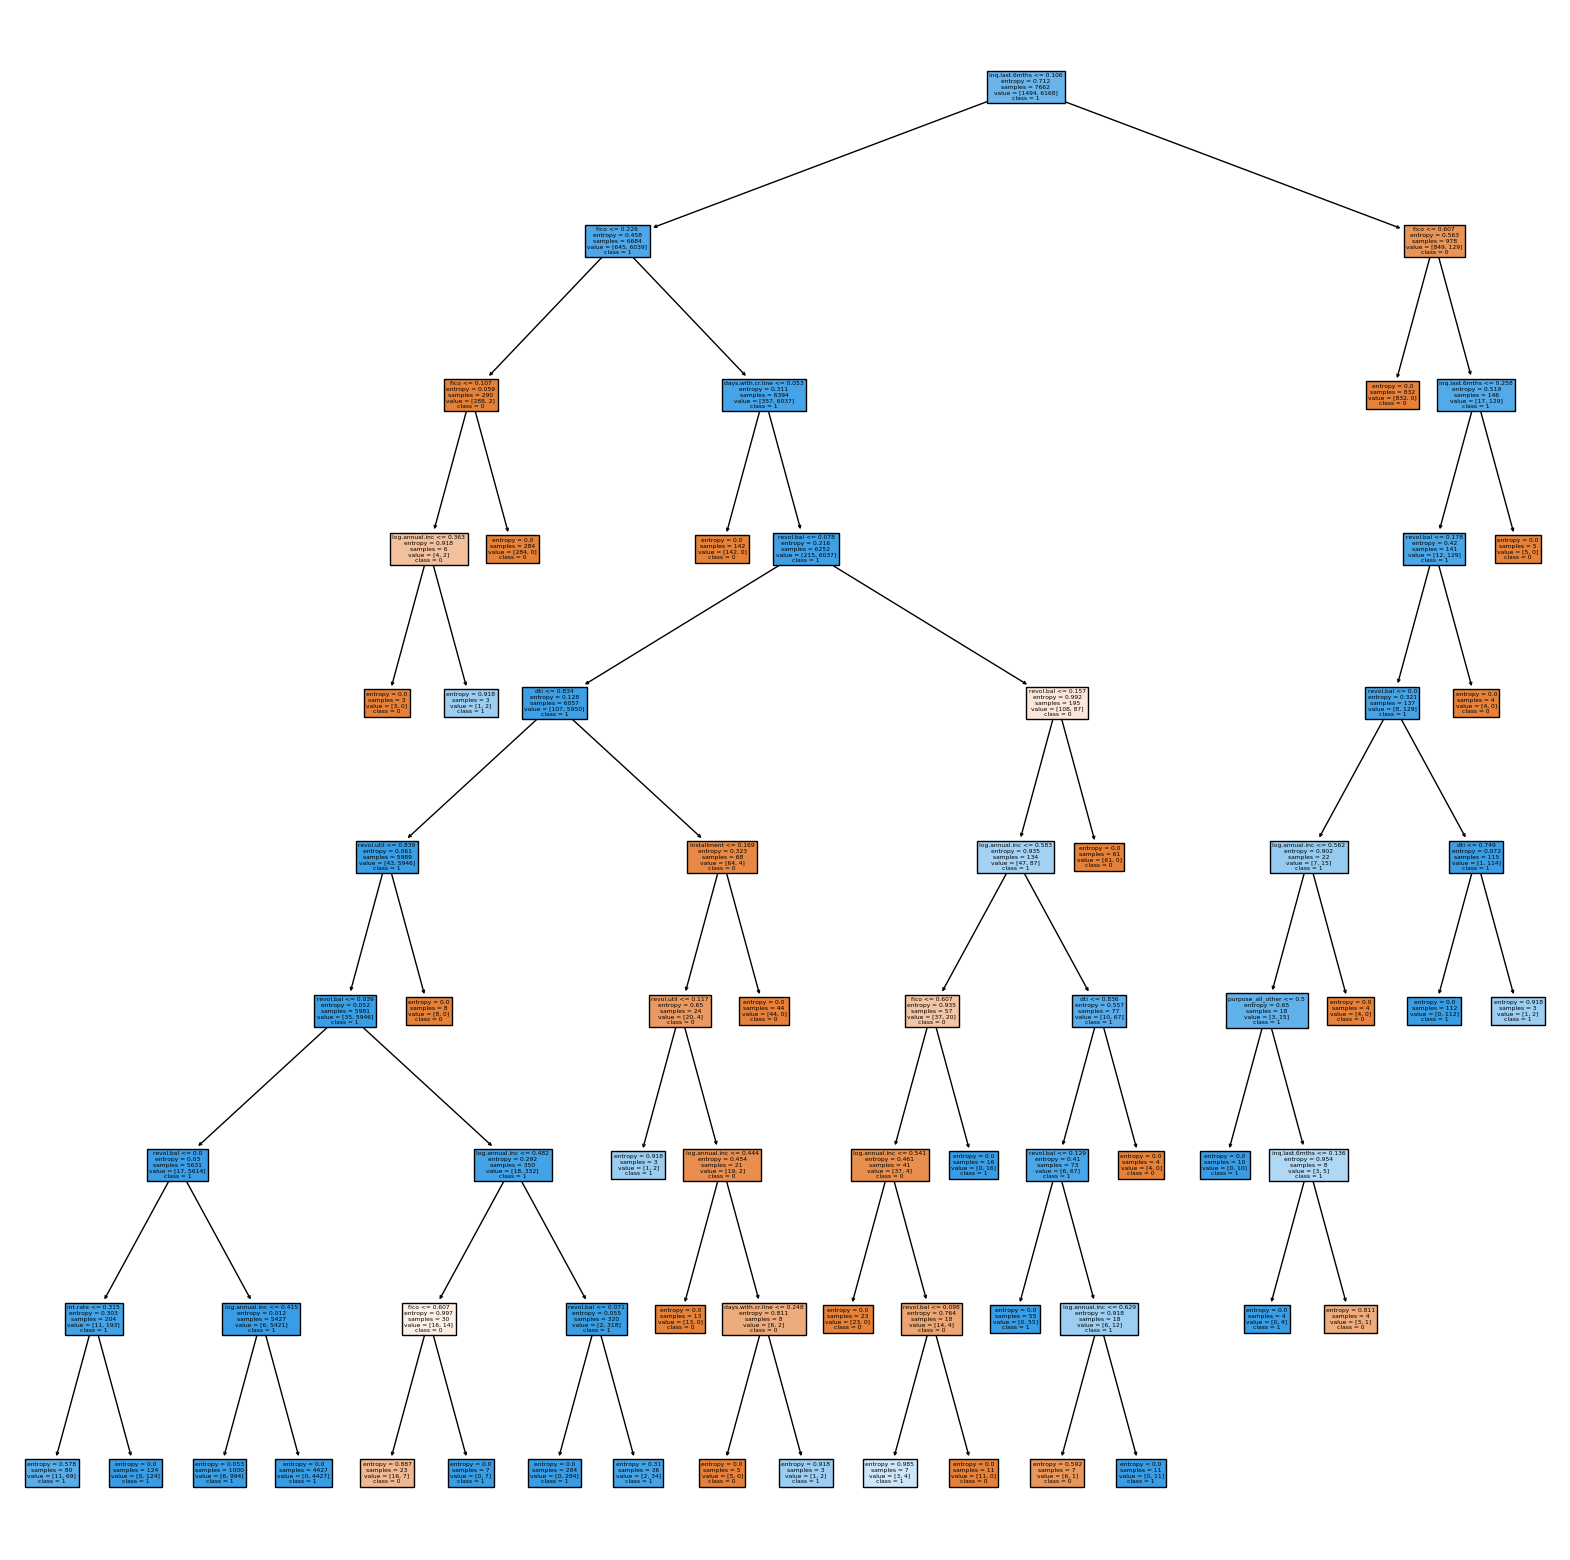

In [198]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.show()

## Random Forest

In [199]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print_metrics(y_test, y_pred)
rf.get_params()

accuracy: 0.9864300626304802
f1: 0.9916398713826367
recall: 1.0
precision: 0.9834183673469388


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [200]:
#grid search for best parameters
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_depth': [3, 5, 7, 9, 'None'],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9],
}

grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy',  verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 3600 candidates, totalling 10800 fits
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.963 total time=   0.0s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.946 total time=   0.0s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.899 total time=   0.0s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.924 total time=   0.0s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.939 total time=   0.1s
[CV 3/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=20;, score=0.888 total time=   0.1s
[CV 1/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.922 total time=   0.1s
[CV 2/3] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=30;, score=0.912 total time=   0.1s
[CV 3/

{'max_depth': 9,
 'min_samples_leaf': 3,
 'min_samples_split': 7,
 'n_estimators': 60}

In [201]:
rf = grid_search.best_estimator_
y_pred = rf.predict(X_test)
print_metrics(y_test, y_pred)

accuracy: 0.982776617954071
f1: 0.989406099518459
recall: 0.9993514915693904
precision: 0.9796567069294342


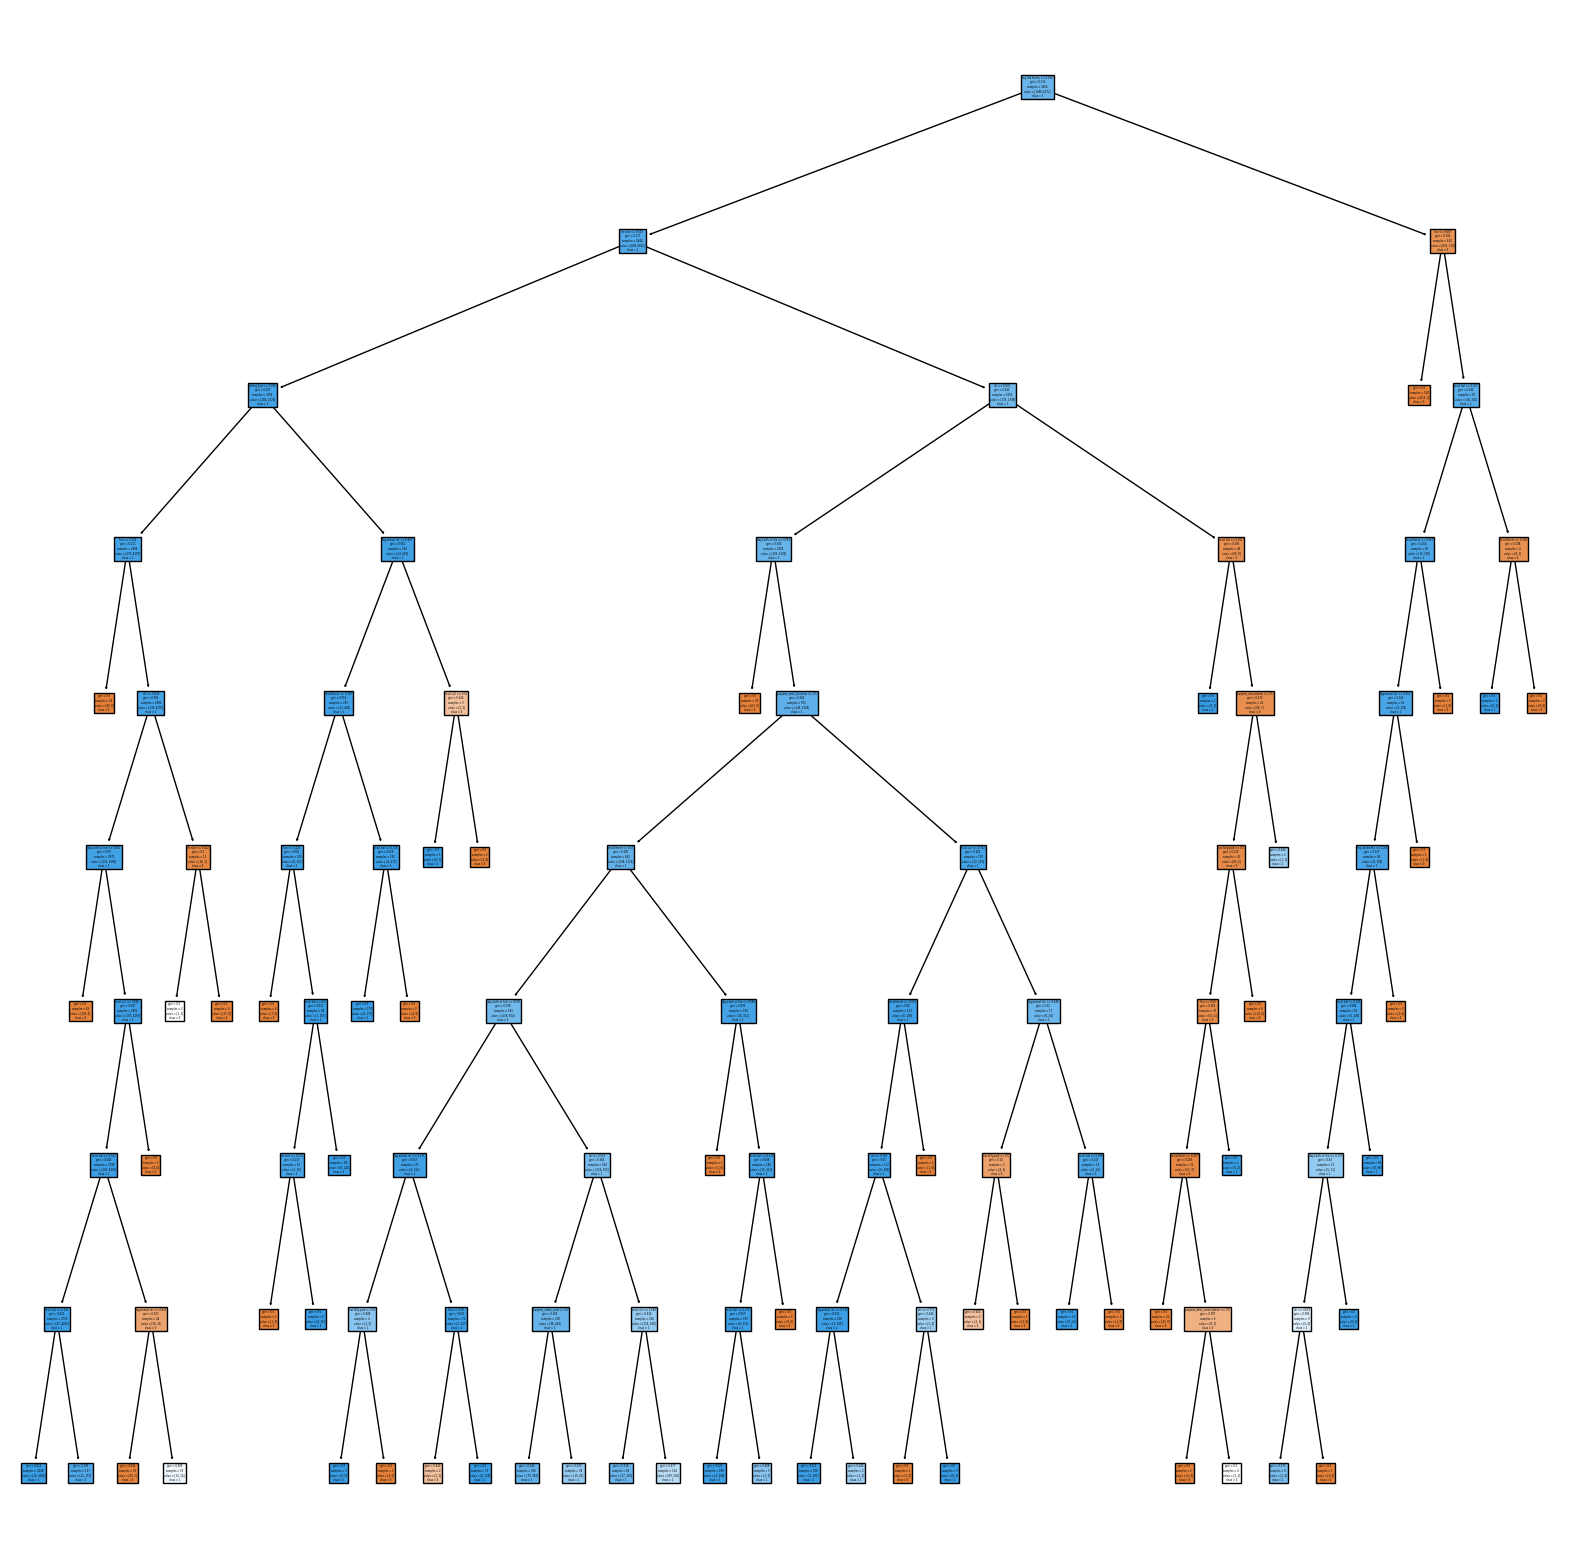

In [160]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 20))
plot_tree(rf.estimators_[0], filled=True, feature_names=X_train.columns, class_names=['0', '1'])
plt.show()

RF:
- accuracy: 0.983
- f1: 0.989
- recall: 0.999
- precision: 0.980

DT:
- accuracy: 0.991
- f1: 0.994
- recall: 0.997
- precision: 0.992

### Questions
1. How did the DT compare to the RF in performance? Why?
    - Overall, the DT model performed better than the RF model in terms of accuracy, precision, and f1-score, likely because it was able to find a more optimal decision boundary for the dataset. However, the RF model achieved a higher recall, which may be useful in certain applications where identifying all positive instances is more important than minimizing false positives.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - After fine-tuning, the maximum depth of both the Decision Tree (DT) and Random Forest (RF) models was set to 9, because it can help prevent overfitting of individual decision trees or one DT and improve the overall performance of the RF model or DT model.
3. What is ensemble learning? What are its pros and cons?
    - Ensemble learning is a technique in machine learning where multiple models are trained and combined to improve the overall predictive performance of the system. Pros: Improved predictive performance, Robustness, Cons: Complexity, Computation, Interpretability
    
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?

    Boosting methods:
    - AdaBoost (Adaptive Boosting): In AdaBoost, multiple weak learners are sequentially trained and combined.
    - Gradient Boosting: In gradient boosting, an ensemble of decision trees is created, where each new tree focuses on the errors of the previous tree. 
    Bagging methods:
    - Random Forest: A random forest is an ensemble of decision trees, where each tree is trained on a random subset of the training data and a random subset of the features.
    - Bootstrap Aggregating (Bagging): In bagging, multiple copies of the original training data are created by random sampling with replacement.